# *CePNEM Auxiliary Notebook v1.0.0*

This notebook contains a collection of miscellaneous supporting analyses used in the paper.

This notebook requires that you have previously run the `CePNEM-analysis.ipynb` notebook on your data. Additionally, a small number of analyses in this notebook require you to manually input data from either other copies of `CePNEM-analysis.ipynb` (eg: copies run on control datasets), or from other sources (eg: the `ANTSUN_NeuroPAL.ipynb` notebook).

## Initialization

In [ ]:
using CePNEMAnalysis, StatsBase, Plots, Plots.PlotMeasures, ProgressMeter, CePNEM, MultivariateStats,
        ColorVectorSpace, MultipleTesting, HDF5, JLD2, Gen, ANTSUNData, FlavellConstants, UMAP, ImageShow, LinearAlgebra,
        ImageCore, Clustering, Images, GLMNet, Combinatorics, Distributions, FlavellBase, ProgressMeter, PyPlot, ANTSUNData, NeuroPALData,
        EncoderModel, AnalysisBase, HypothesisTests, MultipleTesting, PyCall, SpecialFunctions, FileIO, StatsPlots, TotalVariation, DelimitedFiles, Interpolations,
        GLM, DataFrames, KernelDensity, MultiKDE, Optim, ForwardDiff, HierarchicalPosteriorModel, ConnectomePlot, ColorTypes, Random, DataStructures

### Load data

In [ ]:
path_fit_results_lite = "/data1/prj_kfc/data/analysis_dict/fit_results_lite.jld2"
path_analysis_dict = "/data1/prj_kfc/data/analysis_dict/analysis_dict.jld2"

path_fit_results = "/data1/prj_kfc/data/analysis_dict/fit_results.jld2"
path_relative_encoding_strength_dict = "/data1/prj_kfc/data/analysis_dict/relative_encoding_strength.jld2";


In [ ]:
fit_results = Dict()
if isfile(path_fit_results)
    f = JLD2.jldopen(path_fit_results)
    fit_results = f["fit_results"]
    close(f)
end

In [ ]:
relative_encoding_strength = Dict()
if isfile(path_relative_encoding_strength_dict)
    f = JLD2.jldopen(path_relative_encoding_strength_dict)
    relative_encoding_strength = f["relative_encoding_strength"]
    close(f)
end;

In [ ]:
analysis_dict = Dict()
if isfile(path_analysis_dict)
    f = JLD2.jldopen(path_analysis_dict)
    analysis_dict = f["analysis_dict"]
    close(f)
end;

In [ ]:
θh_pos_is_ventral = analysis_dict["θh_pos_is_ventral"];

In [ ]:
path_h5_data = "/data1/prj_kfc/data/processed_h5"


get_h5_data = dataset -> import_data(joinpath(path_h5_data, "$(dataset)-data.h5"))


datasets_gfp = ["2022-01-07-03", "2022-03-16-01", "2022-03-16-02"]
datasets_baseline = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01", "2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"]
datasets_stim = ["2021-09-06-09", "2021-09-14-01", "2021-09-14-05", "2021-09-23-01", "2021-09-30-01"]
datasets_stim_1600 = ["2022-02-08-04", "2022-02-16-01", "2022-02-16-04", "2022-03-15-04", "2022-03-22-01", "2022-04-18-04"]
datasets_neuropal_1600 = ["2022-06-14-01", "2022-06-14-07", "2022-06-14-13", "2022-06-28-01", "2022-06-28-07", "2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-01-19-01", "2023-01-19-08", "2023-01-19-22", "2023-01-09-28", "2023-01-17-01", "2023-01-19-15", "2023-01-23-01", "2023-03-07-01"];
datasets_neuropal_stim = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"]
datasets_neuropal_800 = []
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];


datasets_neuropal = deepcopy(datasets_neuropal_800)
append!(datasets_neuropal, datasets_neuropal_1600)
append!(datasets_neuropal, datasets_neuropal_stim)

datasets_gcamp = String[]
datasets_swf415 = String[]
datasets = String[]
for d in [datasets_baseline, datasets_stim, datasets_stim_1600]
    append!(datasets_gcamp, d)
    append!(datasets, d)
    append!(datasets_swf415, d)
end
append!(datasets, datasets_neuropal)
append!(datasets_gcamp, datasets_neuropal)
append!(datasets, datasets_gfp);

datasets_stim_all = deepcopy(datasets_stim)
append!(datasets_stim_all, datasets_stim_1600);
append!(datasets_stim_all, datasets_neuropal_stim);
datasets_neuropal_baseline = [d for d in datasets_neuropal if !(d in datasets_stim_all)];

In [ ]:
stim_times = Dict()
for dataset in datasets_stim_all
    stim_times[dataset] = Int(get_h5_data(dataset)["stim_begin_confocal"][1])
end

### Plotting parameters

Here, you can set plotting parameters such as the default font, font size, and save location.

In [ ]:
rc_params = PyDict(pyimport("matplotlib")["rcParams"]);
rc_params["font.sans-serif"] = ["Arial"];
rc_params["font.size"] = 7;
fix_plot() = (margins(0.05); tick_params(direction = "out");
    ax = gca(); ax[:xaxis][:tick_bottom]();
    ax[:yaxis][:tick_left]();
    ax[:spines]["top"]["set_visible"](false);
    ax[:spines]["right"]["set_visible"](false););

path_fig_root = "/data1/prj_kfc/figure/manuscript/cell_draft2" # this is where figures will be saved to


"/data1/prj_kfc/figure/manuscript/cell_draft2"

In [ ]:
fnt = Plots.font("Arial", 7)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

default(grid=false)
default(color=:auto)

### Manually specify state changes

For heat-stim datasets, the hypothesized time of state change is always set to the time of the heat-stim. For other datasets, we do not yet have an automated way to detect state changes, so you must manually specify the time of state change for each dataset.
For baseline datasets, we recommend examining the relative model performance plots to determine the time of state change.

We are actively working on improving CePNEM to automate the detection of state changes in baseline datasets.

In [ ]:
manual_hypothesized_state_changes = Dict()
manual_hypothesized_state_changes["2022-04-05-01"] = 9.25
manual_hypothesized_state_changes["2022-08-02-01"] = 3.89;
manual_hypothesized_state_changes["2022-06-14-07"] = 11;
manual_hypothesized_state_changes["2022-06-14-13"] = 8.3;
manual_hypothesized_state_changes["2022-06-28-01"] = 8.0;
manual_hypothesized_state_changes["2022-06-28-07"] = 5.3;
manual_hypothesized_state_changes["2022-07-15-12"] = 7.2;
manual_hypothesized_state_changes["2022-07-20-01"] = 5.2;


### SNR calculation (Figure 1F legend)

In [ ]:
let
    σ_GFP = []
    σ_GCaMP = []
    σ_NeuroPAL = []
    dataset = "2021-05-26-07"
    for dataset = datasets_gfp
        data_dict = import_data("/data1/prj_kfc/data/processed_h5/$(dataset)-data.h5")
        append!(σ_GFP, std(data_dict["trace_array_F20"]))
    end
    for dataset = datasets_baseline
        data_dict = import_data("/data1/prj_kfc/data/processed_h5/$(dataset)-data.h5")
        append!(σ_GCaMP, std(data_dict["trace_array_F20"]))
    end
    for dataset = datasets_neuropal
        data_dict = import_data("/data1/prj_kfc/data/processed_h5/$(dataset)-data.h5")
        append!(σ_NeuroPAL, std(data_dict["trace_array_F20"]))
    end
    println(mean(σ_GFP))
    println(mean(σ_GCaMP))
    println(mean(σ_NeuroPAL))
    println(mean(σ_GCaMP)^2 / mean(σ_GFP)^2)
end

0.0741750486124782
0.3916031634122067
0.3299444405198465
27.872550026381997


## Encoding change statistics between SBC and baseline (Figure S6A), photobleaching control (Figure S6B), and behavior variance comparison (Figure S6L)

To add a new dataset, copy the value from that dataset's `ANTSUN` notebook.

In [ ]:
bleach_str = Dict(
"2022-05-17-01"=> 0.9152490365285075,
"2023-01-17-07"=> 1.051272645243887,
"2022-04-05-01"=> 1.0602189210903121,
"2023-01-16-22"=> 1.0668966763780512,
"2022-07-20-01"=> 1.067419942920339,
"2022-01-09-01"=> 1.0677282993646264,
"2022-06-28-07"=> 1.117074159479684,
"2023-01-23-08"=> 1.1266547471462554,
"2023-01-05-18"=> 1.1324972327573808,
"2023-01-19-15"=> 1.1399555803308576,
"2023-01-17-14"=> 1.1407108067723735,
"2022-07-15-12"=> 1.144345413793659,
"2021-08-04-06"=> 1.1572951076360882,
"2023-01-17-01"=> 1.161108465523721,
"2022-07-26-01"=> 1.171262873883935,
"2023-01-23-21"=> 1.1787082688975161,
"2022-03-22-01"=> 1.1841907609237332,
"2023-01-09-28"=> 1.1862859335245894,
"2021-09-14-05"=> 1.1935957366506862,
"2022-07-15-06"=> 1.202603075904971,
"2022-06-28-01"=> 1.2087190281937725,
"2021-09-06-09"=> 1.2104641991380167,
"2023-01-06-08"=> 1.2137377611866693,
"2022-08-02-01"=> 1.218187302050439,
"2023-01-10-14"=> 1.2189238211341633,
"2021-06-11-01"=> 1.2199323995982483,
"2023-01-16-01"=> 1.2260495257099802,
"2023-01-16-08"=> 1.2276582438414136,
"2023-01-06-15"=> 1.232357066594689,
"2023-01-19-22"=> 1.2379601838305834,
"2022-02-16-04"=> 1.2400790968617033,
"2023-03-07-01"=> 1.2532604819516184,
"2023-01-13-07"=> 1.2579117239528967,
"2022-06-14-07"=> 1.2650704829744326,
"2023-01-16-15"=> 1.2718643073722176,
"2022-05-17-06"=> 1.277174188761404,
"2022-06-14-01"=> 1.279413260625683,
"2022-06-14-13"=> 1.2913058916568545,
"2023-01-19-01"=> 1.3014689962781179,
"2023-01-10-07"=> 1.3020213358899215,
"2023-01-05-01"=> 1.313552357092349,
"2023-01-23-01"=> 1.317685591433623,
"2023-01-09-22"=> 1.336102398778092,
"2023-01-23-15"=> 1.343068268844347,
"2023-01-06-01"=> 1.3470848742437957,
"2023-01-18-01"=> 1.347161029852577,
"2021-11-12-01"=> 1.369653487167133,
"2022-03-15-04"=> 1.3807657125909223,
"2021-11-12-05"=> 1.3927509601772912,
"2022-02-08-04"=> 1.412076985886093,
"2021-09-22-05"=> 1.444588513730372,
"2021-08-17-01"=> 1.4493534444661917,
"2022-04-18-04"=> 1.4630287655205936,
"2023-01-19-08"=> 1.4720887080617044,
"2021-10-26-01"=> 1.511601915686044,
"2023-01-09-08"=> 1.524796532774862,
"2021-09-14-01"=> 1.524877580962184,
"2021-08-18-01"=> 1.5330204286233031,
"2022-12-21-06"=> 1.5371445105523645,
"2022-04-12-04"=> 1.555517695292113,
"2021-09-30-01"=> 1.589844157846058,
"2022-04-14-04"=> 1.6305970466117554,
"2021-05-26-07"=> 1.691438115957138,
"2022-01-17-01"=> 1.7141448610159764,
"2023-01-09-15"=> 1.899800947304601,
"2022-02-16-01"=> 1.9362023806427355,
"2021-09-23-01"=> 2.25471511919632,
"2022-01-27-01"=> 2.373732558183396,
"2022-01-27-04"=> 2.41068146653462,
"2022-05-25-02"=> 2.68789142363121,
"2022-01-23-01"=> 4.55371706305617,
"2022-01-26-01"=> 5.406611185709087,
"2022-01-23-04"=> 5.520334258800602,
"2022-02-08-01"=> 5.529544143074313);

2021-05-26-07
2021-06-11-01
2021-08-04-06
2021-08-17-01
2021-08-18-01
2021-09-22-05
2021-10-26-01
2021-11-12-01
2021-11-12-05
2022-01-09-01
2022-01-17-01
2022-04-05-01
2022-04-12-04
2022-04-14-04
0.3073630136986301


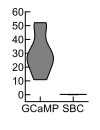

In [ ]:
let
    k = "enc_stat_dict"
    save_fig = false
    plot_type = "SBC" # set to "bleach" to plot encoding change vs bleaching, "SBC" to plot SBC control, or "beh_var" to plot encoding change vs behavioral variability
    ec_frac_sbc = [0.0, 0.002277904328018223, 0.0026595744680851063, 0.002145922746781116] # compute from running the `CePNEM-analysis.ipynb` notebook on SBC control data

    n_ec = 0
    n_enc = 0
    beh_diff = []
    bleach = []
    gap_t = []
    ec_frac = []
    for dataset in datasets_baseline
        println(dataset)
        n_enc_ = analysis_dict[k][dataset]["n_neurons_tot_all"] - analysis_dict[k][dataset]["n_neurons_npred"][1]
        n_ec_ = length(analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"])
        n_enc += n_enc_
        n_ec += n_ec_
        data_dict = import_data("/data1/prj_kfc/data/processed_h5/$(dataset)-data.h5")
        push!(gap_t, (data_dict["timestamp_confocal"][801] - data_dict["timestamp_confocal"][800]) / 60)
        push!(ec_frac, n_ec_ / n_enc_)
        push!(bleach, bleach_str[dataset])
        push!(beh_diff, (abs(analysis_dict["v_ranges"][dataset][2][4] - analysis_dict["v_ranges"][dataset][1][4]) + abs(analysis_dict["v_ranges"][dataset][2][1] - analysis_dict["v_ranges"][dataset][1][1])) / v_STD +
                (abs(analysis_dict["θh_ranges"][dataset][2][2] - analysis_dict["θh_ranges"][dataset][1][2]) + abs(analysis_dict["θh_ranges"][dataset][2][1] - analysis_dict["θh_ranges"][dataset][1][1])) / θh_STD +
                (abs(analysis_dict["P_ranges"][dataset][2][2] - analysis_dict["P_ranges"][dataset][1][2]) + abs(analysis_dict["P_ranges"][dataset][2][1] - analysis_dict["P_ranges"][dataset][1][1])) / P_STD)
    end
    μ_GCaMP = mean(ec_frac)
    σ_GCaMP = std(ec_frac)
    
    println(n_ec / n_enc)
    
    μ_SBC = mean(ec_frac_sbc)
    σ_SBC = std(ec_frac_sbc)

    if plot_type == "bleach"
        PyPlot.figure(figsize=(1.5,1.5))
        PyPlot.scatter(bleach, 100 .*ec_frac, color="gray", s=10)
        PyPlot.ylim(0,60)
        PyPlot.xlim(1,1.8)
        PyPlot.xticks(1:0.2:1.8)

        fix_plot()
        tight_layout()
    
        if save_fig
            create_dir(joinpath(path_fig_root, "figureS6"))
            PyPlot.savefig(joinpath(path_fig_root, "figureS6/ec_bleach_controls.pdf"))
            PyPlot.savefig(joinpath(path_fig_root, "figureS6/ec_bleach_controls.png"))
        end
    elseif plot_type == "beh_var"
        PyPlot.figure(figsize=(1.5,1.5))
        PyPlot.scatter(beh_diff, 100 .*ec_frac, color="gray", s=10)

        PyPlot.ylim(0,60)
        PyPlot.xlim(0,8)
        PyPlot.xticks(0:2:8)

        fix_plot()
        tight_layout()

        if save_fig
            create_dir(joinpath(path_fig_root, "figureS6"))
            PyPlot.savefig(joinpath(path_fig_root, "figureS6/ec_vs_beh_var.pdf"))
            PyPlot.savefig(joinpath(path_fig_root, "figureS6/ec_vs_beh_var.png"))
        end
    elseif plot_type == "SBC"
        Plots.plot(size=(100,130), xguidefont=font("Arial", 5), yguidefont=font("Arial", 5))
        Plots.violin!(ec_frac .* 100, color="gray", label=nothing)
        Plots.violin!(ec_frac_sbc .* 100, color="gray", label=nothing)
        Plots.xticks!(1:2, ["GCaMP", "SBC"])
        Plots.yaxis!((-5,60), xguidefont=font("Arial", 5), yguidefont=font("Arial", 5))
        if save_fig
            create_dir(joinpath(path_fig_root, "figureS6"))
            Plots.savefig(joinpath(path_fig_root, "figureS6/ec_freq_controls.pdf"))
            Plots.savefig(joinpath(path_fig_root, "figureS6/ec_freq_controls.png"))
        end
        Plots.plot!()
    else
        error("invalid plot type")
    end
end

## Baseline PCA analysis (Figure 2E and S13)

0.7533820599895387


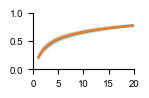

In [ ]:
let
    save_fig = false # whether to save the figure
    include_neuropal = true # whether to include neuropal data
    n_pc = 20 # number of principal components to use

    varexp = zeros(length(datasets_baseline), n_pc)
    varexp_neuropal = zeros(length(datasets_neuropal_baseline), n_pc)
    analysis_dict["pca"] = Dict()
    for (i,dataset) = enumerate(datasets_baseline)
        traces = fit_results[dataset]["trace_array"]
        trace_pca = fit(PCA, traces)
        analysis_dict["pca"][dataset] = trace_pca
        varexp[i,:] .= cumsum(trace_pca.prinvars[1:n_pc] ./ trace_pca.tvar)
    end
    
    for (i,dataset) = enumerate(datasets_neuropal_baseline)
        traces = fit_results[dataset]["trace_array"]
        trace_pca = fit(PCA, traces)
        analysis_dict["pca"][dataset] = trace_pca
        varexp_neuropal[i,:] .= cumsum(trace_pca.prinvars[1:n_pc] ./ trace_pca.tvar)
    end

    x = meanprj(varexp, dims=1)
    s = dropdims(std(varexp, dims=1), dims=1) # ./ sqrt(length(list_uid_baseline))
    
    y1 = x .- s
    y2 = x 
    y3 = x .+ s
    
    if include_neuropal
        figure(figsize=(1.5,1))
    else
        figure(figsize=(3,2))
    end
    println(y2[18])
    if include_neuropal
        PyPlot.plot(1:n_pc, y2, label=nothing)
        PyPlot.fill_between(1:n_pc, y1, y3, alpha=0.3)
    else
        PyPlot.plot(1:n_pc, y2, color="black")
        PyPlot.fill_between(1:n_pc, y1, y3, color="black", alpha=0.3)
    end

    if include_neuropal
        x = meanprj(varexp_neuropal, dims=1)
        s = dropdims(std(varexp_neuropal, dims=1), dims=1) # ./ sqrt(length(list_uid_baseline))
        
        y1 = x .- s
        y2 = x 
        y3 = x .+ s
        PyPlot.plot(1:n_pc, y2, label=nothing)
        PyPlot.fill_between(1:n_pc, y1, y3, alpha=0.3)
    end
    
    if !include_neuropal
        PyPlot.xlabel("PC #")
        PyPlot.ylabel("Cumulative variance explained")
    end
    PyPlot.ylim(0,1)
    PyPlot.xlim(0,20)
    PyPlot.xticks(0:5:20)
        
    fix_plot()
    tight_layout()

    if save_fig && !include_neuropal
        create_dir(joinpath(path_fig_root, "figureS3"))
        create_dir(joinpath(path_fig_root, "figureS3/pca"))
        PyPlot.savefig(joinpath(path_fig_root, "figureS3/pca/pca_variance_explained_baseline.pdf"))
    elseif save_fig && include_neuropal
        create_dir(joinpath(path_fig_root, "figureS4"))
        create_dir(joinpath(path_fig_root, "figureS4/pca"))
        PyPlot.savefig(joinpath(path_fig_root, "figureS4/pca/pca_variance_explained_baseline_neuropal.pdf"))
    end
#     PyPlot.plot(trace_pca)
end

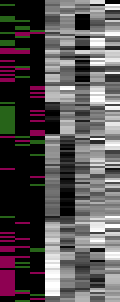

In [ ]:
let
    save_fig = false
    dataset = "2022-04-12-04"
    trace_pca = analysis_dict["pca"][dataset]
    
    n_pc = 5
    x_scale = 15
    y_scale = 2
    img = zeros(RGB, y_scale * size(trace_pca, 1), x_scale * (n_pc + 3))
    
    min_val = -0.15
    max_val = 0.15
    
    cmap = x->clamp((x-min_val)/(max_val-min_val), 0, 1)
    cmap_rgb = x->RGB(cmap(x), cmap(x), cmap(x))
    
    weighted_proj = deepcopy(trace_pca.proj)
    for i=1:size(weighted_proj, 2)
        weighted_proj[:,i] .*= trace_pca.prinvars[i]
    end
    
    
    clustered_proj = hclust(make_distance_matrix(weighted_proj[:,1:n_pc]))
    
    behs = ["v", "θh", "P"]
    sub_behs = [["fwd", "rev"], ["dorsal", "ventral"], ["act", "inh"]]
    for i=1:size(trace_pca,1)
        n = clustered_proj.order[i]
        for (j,beh) in enumerate(behs)
            assigned = 0
            switch = false
            for (k,sb) in enumerate(sub_behs[j])
                for rng=1:2
                    if n in analysis_dict["neuron_categorization"][dataset][rng][beh][sb]
                        if assigned != k && assigned != 0
                            @warn("Neuron $(i) switched encoding")
                            switch = true # had neuron switch from fwd->rev or vice versa; exclude.
                        else
                            assigned = k
                        end
                    end
                end
            end
            if assigned > 0 && !switch         
                img[y_scale*(i-1)+1:y_scale*i,x_scale*(j-1)+1:x_scale*(j)] .= (assigned == 1 ? palette(:PiYG)[1] : palette(:PiYG)[end])
            end
        end
    end
    
    for i=1:size(trace_pca,1)
        for j=1:n_pc
            img[y_scale*(i-1)+1:y_scale*i,x_scale*(j+2)+1:x_scale*(j+3)] .= cmap_rgb(trace_pca.proj[clustered_proj.order[i],j])
        end
    end
    

    if save_fig
        create_dir(joinpath(path_fig_root, "figure2/beh_vs_clustered_pcs"))
        Images.save(joinpath(path_fig_root, "figure2/beh_vs_clustered_pcs.pdf"), img)
        Images.save(joinpath(path_fig_root, "figure2/beh_vs_clustered_pcs.png"), img)
    end
    img
end

## Decoding analysis (Figure S2E)

### Compute neuron predictive power of different behavioral variables

In [ ]:
λ_vals = [2e-5*1.1^i for i=0:120] # regularization terms
decode_vars = ["v", "θh", "P", "ang_vel", "curve"]
t_val = [1:320, 321:640, 641:960, 961:1280, 1281:1600];


11-element Vector{String}:
 "2021-05-26-07"
 "2021-08-04-06"
 "2021-08-17-01"
 "2021-08-18-01"
 "2021-10-26-01"
 "2021-11-12-01"
 "2021-11-12-05"
 "2022-01-09-01"
 "2022-01-17-01"
 "2022-04-05-01"
 "2022-04-14-04"

In [ ]:
analysis_dict["decoder_prediction_quality"] = Dict();
analysis_dict["decoder_prediction"] = Dict();

In [ ]:
dsets_reg = [rand(datasets_baseline) for i=1:3]
for i=1:length(dsets_reg)
    while std(fit_results[dsets_reg[i]]["P"]) < 0.5
        dsets_reg[i] = rand(datasets_baseline)
    end
end

In [ ]:
analysis_dict["dsets_reg"] = dsets_reg

3-element Vector{String}:
 "2021-09-22-05"
 "2021-06-11-01"
 "2022-04-12-04"

In [ ]:
dsets_test = [dataset for dataset in datasets_baseline if !(dataset in analysis_dict["dsets_reg"])]

In [ ]:
let
    λ_dict = Dict()
    for beh = decode_vars
        λ_dict[beh] = λ_vals
    end
    dict_sol, dict_pred, dict_cost = fit_decoder(fit_results, analysis_dict["dsets_reg"], decode_vars, t_val, λ_dict)
    analysis_dict["opt_λ_idx"] = Dict()
    analysis_dict["opt_λ"] = Dict()
    dict_quality = compute_variance_explained(dict_cost, fit_results, t_val, decode_vars, λ_dict)
    
    
    for beh = decode_vars
        reg_qual = [mean(dict_quality[beh][i]["overall"]) for i=1:length(λ_dict[beh])]
        analysis_dict["opt_λ_idx"][beh] = argmax(reg_qual)
        println(maximum(reg_qual))
        analysis_dict["opt_λ"][beh] = [λ_dict[beh][analysis_dict["opt_λ_idx"][beh]]]
    end

    analysis_dict["opt_λ"]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


0.7020456513341204
0.5352932896650112
0.8546193548027262
0.1193693136265954
0.6348348554254248


Dict{Any, Any} with 5 entries:
  "v"       => [0.014359]
  "ang_vel" => [0.0173744]
  "θh"      => [0.00980741]
  "P"       => [0.0130537]
  "curve"   => [0.0307799]

In [ ]:
analysis_dict["median_combined_gen_fits"] = Dict()
analysis_dict["median_combined_gen_resid"] = Dict()

@showprogress for dataset = datasets_baseline
    model_traces = zeros(size(fit_results[dataset]["trace_array"])...)
    model_resid = zeros(size(fit_results[dataset]["trace_array"])...)
    
    for neuron=1:size(model_traces,1)
        ps1 = median(fit_results[dataset]["sampled_trace_params"][1,neuron,:,1:8], dims=1)[1,:]
        model_traces[neuron,1:800] .= model_nl8(800, ps1..., fit_results[dataset]["v"][1:800], fit_results[dataset]["θh"][1:800], fit_results[dataset]["P"][1:800])
        ps2 = median(fit_results[dataset]["sampled_trace_params"][2,neuron,:,1:8], dims=1)[1,:]
        model_traces[neuron,801:1600] .= model_nl8(800, ps2..., fit_results[dataset]["v"][801:1600], fit_results[dataset]["θh"][801:1600], fit_results[dataset]["P"][801:1600])
        model_resid[neuron,:] .= zscore(fit_results[dataset]["trace_array"][neuron,:] .- model_traces[neuron,:])
        model_traces[neuron,:] .= zscore(model_traces[neuron,:])
    end
    analysis_dict["median_combined_gen_fits"][dataset] = model_traces
    analysis_dict["median_combined_gen_resid"][dataset] = model_resid
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [ ]:
let
    λ_dict = Dict()
    for beh = decode_vars
        λ_dict[beh] = λ_vals
    end
    dict_sol, dict_pred, dict_cost = fit_decoder(fit_results, analysis_dict["dsets_reg"], decode_vars, t_val, λ_dict, traces_use=analysis_dict["median_combined_gen_resid"])
    analysis_dict["opt_λ_idx_resid"] = Dict()
    analysis_dict["opt_λ_resid"] = Dict()
    dict_quality = compute_variance_explained(dict_cost, fit_results, t_val, decode_vars, λ_dict)
    
    
    for beh = decode_vars
        reg_qual = [mean(dict_quality[beh][i]["overall"]) for i=1:length(λ_dict[beh])]
        analysis_dict["opt_λ_idx_resid"][beh] = argmax(reg_qual)
        println(maximum(reg_qual))
        analysis_dict["opt_λ_resid"][beh] = [λ_dict[beh][analysis_dict["opt_λ_idx_resid"][beh]]]
    end

    analysis_dict["opt_λ_resid"]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


0.27548773077740996
0.1922388039601233
0.00090962179679089
0.033786361141760035
0.4001675159748286


Dict{Any, Any} with 5 entries:
  "v"       => [0.0210231]
  "ang_vel" => [0.116886]
  "θh"      => [0.0231254]
  "P"       => [0.488264]
  "curve"   => [0.0173744]

In [ ]:
sub_behs_use = Dict("v" => [["all"], ["rev", "fwd"], ["fwd_slope_pos", "fwd_slope_neg"], ["rev_slope_pos", "rev_slope_neg"], ["rect_pos", "rect_neg"]],
        "θh" => [["all"], ["dorsal", "ventral"], ["fwd_dorsal", "fwd_ventral"], ["rev_dorsal", "rev_ventral"], ["rect_dorsal", "rect_ventral"]],
        "P" => [["all"], ["act", "inh"], ["fwd_act", "fwd_inh"], ["rev_act", "rev_inh"], ["rect_act", "rect_inh"]])

Dict{String, Vector{Vector{String}}} with 3 entries:
  "v"  => [["all"], ["rev", "fwd"], ["fwd_slope_pos", "fwd_slope_neg"], ["rev_s…
  "θh" => [["all"], ["dorsal", "ventral"], ["fwd_dorsal", "fwd_ventral"], ["rev…
  "P"  => [["all"], ["act", "inh"], ["fwd_act", "fwd_inh"], ["rev_act", "rev_in…

In [ ]:
let
    analysis_dict["opt_λ_idx_categorizations"] = Dict()
    analysis_dict["opt_λ_categorizations"] = Dict()

    for beh_test = ["v", "θh", "P"]
        analysis_dict["opt_λ_idx_categorizations"][beh_test] = Dict()
        analysis_dict["opt_λ_categorizations"][beh_test] = Dict()

        for sub_beh_test = sub_behs_use[beh_test]
            analysis_dict["opt_λ_idx_categorizations"][beh_test][sub_beh_test] = Dict()
            analysis_dict["opt_λ_categorizations"][beh_test][sub_beh_test] = Dict()
            for velocity_condition = ["all", "fwd", "rev"]
                analysis_dict["opt_λ_idx_categorizations"][beh_test][sub_beh_test][velocity_condition] = Dict()
                analysis_dict["opt_λ_categorizations"][beh_test][sub_beh_test][velocity_condition] = Dict()

                λ_dict = Dict()
                for beh = decode_vars
                    λ_dict[beh] = λ_vals
                end

                traces_use = get_all_neurons_with_feature(fit_results, analysis_dict, beh_test, sub_beh_test)[2]                

                dict_sol, dict_pred, dict_cost = fit_decoder_(fit_results, analysis_dict["dsets_reg"], decode_vars, t_val, λ_dict, traces_use=traces_use, v_condition=velocity_condition)

                dict_quality = compute_variance_explained_(dict_cost, fit_results, t_val, decode_vars, λ_dict)
                
                
                for beh = decode_vars
                    reg_qual = [mean(dict_quality[beh][i]["overall"]) for i=1:length(λ_dict[beh])]
                    analysis_dict["opt_λ_idx_categorizations"][beh_test][sub_beh_test][velocity_condition][beh] = argmax(reg_qual)
                    analysis_dict["opt_λ_categorizations"][beh_test][sub_beh_test][velocity_condition][beh] = [λ_dict[beh][analysis_dict["opt_λ_idx_categorizations"][beh_test][sub_beh_test][velocity_condition][beh]]]
                end
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

In [ ]:
sub_behs_use = Dict("v" => [["fwd_slope_pos", "fwd_slope_neg"], ["rev_slope_pos", "rev_slope_neg"]],
        "θh" => [["fwd_dorsal", "fwd_ventral"], ["rev_dorsal", "rev_ventral"]],
        "P" => [["all"]])

Dict{String, Vector{Vector{String}}} with 3 entries:
  "v"  => [["fwd_slope_pos", "fwd_slope_neg"], ["rev_slope_pos", "rev_slope_neg…
  "θh" => [["fwd_dorsal", "fwd_ventral"], ["rev_dorsal", "rev_ventral"]]
  "P"  => [["all"]]

In [ ]:
let
    analysis_dict["opt_λ_idx_categorizations_shuffle"] = Dict()
    analysis_dict["opt_λ_categorizations_shuffle"] = Dict()
    
    n_samples = 500

    for beh_test = ["v", "θh", "P"]
        analysis_dict["opt_λ_idx_categorizations_shuffle"][beh_test] = Dict()
        analysis_dict["opt_λ_categorizations_shuffle"][beh_test] = Dict()

        for sub_beh_test = sub_behs_use[beh_test]
            analysis_dict["opt_λ_idx_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
            analysis_dict["opt_λ_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
            for velocity_condition = ["all", "fwd", "rev"]
                analysis_dict["opt_λ_idx_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = Dict()
                analysis_dict["opt_λ_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = Dict()

                λ_dict = Dict()
                for beh = decode_vars
                    λ_dict[beh] = λ_vals
                end

                neurons_with_beh = get_all_neurons_with_feature(fit_results, analysis_dict, beh_test, sub_beh_test)[1]
                println(sum([length(neurons_with_beh[dataset]) for dataset in keys(neurons_with_beh)]))

                dict_qualities = []
                for i=1:n_samples
                    traces_use = get_random_sample_without_feature(fit_results, analysis_dict, neurons_with_beh)[2]

                    dict_sol, dict_pred, dict_cost = fit_decoder_(fit_results, analysis_dict["dsets_reg"], decode_vars, t_val, λ_dict, traces_use=traces_use, v_condition=velocity_condition)

                    push!(dict_qualities, compute_variance_explained_(dict_cost, fit_results, t_val, decode_vars, λ_dict))
                end
                
                dict_quality = average_dict_qualities(dict_qualities)                
                
                for beh = decode_vars
                    reg_qual = [mean(dict_quality[beh][i]["overall"]) for i=1:length(λ_dict[beh])]
                    analysis_dict["opt_λ_idx_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition][beh] = argmax(reg_qual)
                    analysis_dict["opt_λ_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition][beh] = [λ_dict[beh][analysis_dict["opt_λ_idx_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition][beh]]]
                end
            end
        end
    end
end

1503
1503
1503
1840
1840
1840
1201
1201
1201
440
440
440
728
728
728


In [ ]:
let
    λ_dict = Dict()
    for beh = decode_vars
        λ_dict[beh] = λ_vals
    end
    dict_sol, dict_pred, dict_cost = fit_decoder(fit_results, analysis_dict["dsets_reg"], decode_vars, t_val, λ_dict, traces_use=analysis_dict["median_combined_gen_fits"])
    analysis_dict["opt_λ_idx_model"] = Dict()
    analysis_dict["opt_λ_model"] = Dict()
    dict_quality = compute_variance_explained(dict_cost, fit_results, t_val, decode_vars, λ_dict)
    
    
    for beh = decode_vars
        reg_qual = [mean(dict_quality[beh][i]["overall"]) for i=1:length(λ_dict[beh])]
        analysis_dict["opt_λ_idx_model"][beh] = argmax(reg_qual)
        println(maximum(reg_qual))
        analysis_dict["opt_λ_model"][beh] = [λ_dict[beh][analysis_dict["opt_λ_idx_model"][beh]]]
    end

    analysis_dict["opt_λ_model"]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


0.9466391905669025
0.8640142390371949
0.9835211657291159
0.1276140219359262
0.4156976050477985


Dict{Any, Any} with 5 entries:
  "v"       => [0.000680079]
  "ang_vel" => [0.0210231]
  "θh"      => [0.00457523]
  "P"       => [0.000995704]
  "curve"   => [0.0966004]

In [ ]:
analysis_dict["decoder_solution"], analysis_dict["decoder_prediction"], analysis_dict["decoder_prediction_cost"] = fit_decoder(fit_results, dsets_test, decode_vars, t_val, analysis_dict["opt_λ"]);
analysis_dict["decoder_prediction_quality"] = compute_variance_explained(analysis_dict["decoder_prediction_cost"], fit_results, t_val, decode_vars, analysis_dict["opt_λ"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [ ]:
analysis_dict["decoder_solution_resid"], analysis_dict["decoder_prediction_resid"], analysis_dict["decoder_prediction_cost_resid"] = fit_decoder(fit_results, dsets_test, decode_vars, t_val, analysis_dict["opt_λ_resid"], traces_use=analysis_dict["median_combined_gen_resid"]);
analysis_dict["decoder_prediction_quality_resid"] = compute_variance_explained(analysis_dict["decoder_prediction_cost_resid"], fit_results, t_val, decode_vars, analysis_dict["opt_λ_resid"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [ ]:

analysis_dict["decoder_solution_categorizations"] = Dict()
analysis_dict["decoder_prediction_categorizations"] = Dict()
analysis_dict["decoder_prediction_cost_categorizations"] = Dict()
analysis_dict["decoder_prediction_quality_categorizations"] = Dict()

for beh_test = ["v", "θh", "P"]
    analysis_dict["decoder_solution_categorizations"][beh_test] = Dict()
    analysis_dict["decoder_prediction_categorizations"][beh_test] = Dict()
    analysis_dict["decoder_prediction_cost_categorizations"][beh_test] = Dict()
    analysis_dict["decoder_prediction_quality_categorizations"][beh_test] = Dict()

    for sub_beh_test = sub_behs_use[beh_test]
        analysis_dict["decoder_solution_categorizations"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_categorizations"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_cost_categorizations"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_quality_categorizations"][beh_test][sub_beh_test] = Dict()
        traces_use = get_all_neurons_with_feature(fit_results, analysis_dict, beh_test, sub_beh_test)[2]                
        for velocity_condition = ["all", "fwd", "rev"]
            analysis_dict["decoder_solution_categorizations"][beh_test][sub_beh_test][velocity_condition], analysis_dict["decoder_prediction_categorizations"][beh_test][sub_beh_test][velocity_condition], analysis_dict["decoder_prediction_cost_categorizations"][beh_test][sub_beh_test][velocity_condition] = fit_decoder_(fit_results, dsets_test, decode_vars, t_val, analysis_dict["opt_λ_categorizations"][beh_test][sub_beh_test][velocity_condition], traces_use=traces_use, v_condition=velocity_condition)
            analysis_dict["decoder_prediction_quality_categorizations"][beh_test][sub_beh_test][velocity_condition] = compute_variance_explained_(analysis_dict["decoder_prediction_cost_categorizations"][beh_test][sub_beh_test][velocity_condition], fit_results, t_val, decode_vars, analysis_dict["opt_λ_categorizations"][beh_test][sub_beh_test][velocity_condition])
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

In [ ]:

analysis_dict["decoder_solution_categorizations_shuffle"] = Dict()
analysis_dict["decoder_prediction_categorizations_shuffle"] = Dict()
analysis_dict["decoder_prediction_cost_categorizations_shuffle"] = Dict()
analysis_dict["decoder_prediction_quality_categorizations_shuffle"] = Dict()

for beh_test = ["v", "θh", "P"]
    n_samples = 500
    analysis_dict["decoder_solution_categorizations_shuffle"][beh_test] = Dict()
    analysis_dict["decoder_prediction_categorizations_shuffle"][beh_test] = Dict()
    analysis_dict["decoder_prediction_cost_categorizations_shuffle"][beh_test] = Dict()
    analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh_test] = Dict()

    for sub_beh_test = sub_behs_use[beh_test]
        analysis_dict["decoder_solution_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_cost_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
        analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh_test][sub_beh_test] = Dict()
        for velocity_condition = ["all", "fwd", "rev"]
            neurons_with_beh = get_all_neurons_with_feature(fit_results, analysis_dict, beh_test, sub_beh_test)[1]
            analysis_dict["decoder_solution_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = []
            analysis_dict["decoder_prediction_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = []
            analysis_dict["decoder_prediction_cost_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = []
            analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition] = []
            for i=1:n_samples
                traces_use = get_random_sample_without_feature(fit_results, analysis_dict, neurons_with_beh)[2]
                sol, pred, cost = fit_decoder_(fit_results, dsets_test, decode_vars, t_val, analysis_dict["opt_λ_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition], traces_use=traces_use, v_condition=velocity_condition)
                push!(analysis_dict["decoder_solution_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition], sol)
                push!(analysis_dict["decoder_prediction_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition], pred)
                push!(analysis_dict["decoder_prediction_cost_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition], cost)
                push!(analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition], compute_variance_explained_(cost, fit_results, t_val, decode_vars, analysis_dict["opt_λ_categorizations_shuffle"][beh_test][sub_beh_test][velocity_condition]))
            end
        end
    end
end


┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01
└ @ Main In[355]:18
┌ Warning: No neurons for dataset 2021-11-12-01


0.0
0.008
0.0
0.0
0.0


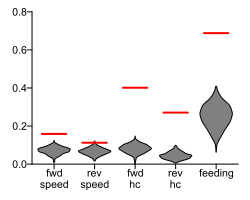

In [ ]:
let
    StatsPlots.plot(size=(250,200), xtickfont=font("Arial", 7, "black"), ytickfont=font("Arial", 7, "black"), tick_direction=:out)

    true_values = Float64[]
    for (beh, beh_rng) = [("v", "fwd"), ("v", "rev"), ("θh", "fwd"), ("θh", "rev"), ("P", "all")]
        quality = Float64[]

        if beh == "v" && beh_rng == "fwd"
            sub_beh = ["fwd_slope_pos", "fwd_slope_neg"]
        elseif beh == "v" && beh_rng == "rev"
            sub_beh = ["rev_slope_pos", "rev_slope_neg"]
        elseif beh == "θh" && beh_rng == "fwd"
            sub_beh = ["fwd_dorsal", "fwd_ventral"]
        elseif beh == "θh" && beh_rng == "rev"
            sub_beh = ["rev_dorsal", "rev_ventral"]
        elseif beh == "P" && beh_rng == "all"
            sub_beh = ["all"]
        end
        beh_test = beh
        for i=1:length(analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh][sub_beh][beh_rng])
            append!(quality, mean(analysis_dict["decoder_prediction_quality_categorizations_shuffle"][beh][sub_beh][beh_rng][i][beh_test][1]["overall_dataset"]))
        end
        StatsPlots.violin!(quality, density=true, color="grey", label=nothing)
        true_value = mean(analysis_dict["decoder_prediction_quality_categorizations"][beh][sub_beh][beh_rng][beh_test][1]["overall_dataset"])
        perc = sum(quality .> true_value) / length(quality)
        println(perc)

        push!(true_values, true_value)
    end

    for (i, true_value) in enumerate(true_values)
        Plots.plot!([i-0.3, i+0.3], [true_value, true_value], label=nothing, color="red", linewidth=2)
    end
    StatsPlots.xticks!(1:5, ["fwd\nspeed", "rev\nspeed", "fwd\nhc", "rev\nhc", "feeding"])
    StatsPlots.ylims!(0,0.8)

    Plots.savefig(joinpath(path_fig_root, "figureS2", "decoder_quality_comparison.pdf"))
    Plots.plot!()
end

In [ ]:
analysis_dict["decoder_solution_model"], analysis_dict["decoder_prediction_model"], analysis_dict["decoder_prediction_cost_model"] = fit_decoder(fit_results, dsets_test, decode_vars, t_val, analysis_dict["opt_λ_model"], traces_use=analysis_dict["median_combined_gen_fits"]);
analysis_dict["decoder_prediction_quality_model"] = compute_variance_explained(analysis_dict["decoder_prediction_cost_model"], fit_results, t_val, decode_vars, analysis_dict["opt_λ_model"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [ ]:
inf_reg = Dict()
for beh = decode_vars
    inf_reg[beh] = [1000.]
end

In [ ]:
analysis_dict["decoder_solution_zero"], analysis_dict["decoder_prediction_zero"], analysis_dict["decoder_prediction_cost_zero"] = fit_decoder(fit_results, dsets_test, decode_vars, t_val, inf_reg);
analysis_dict["decoder_prediction_quality_zero"] = compute_variance_explained(analysis_dict["decoder_prediction_cost_zero"], fit_results, t_val, decode_vars, inf_reg);

### Plot decoder performance using neurons vs model residuals

0.6986564168684303
0.46880495187963067
0.6648774642333468
0.21605887494816245
0.501058534502702


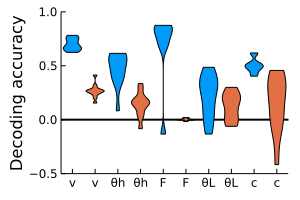

In [ ]:
let
    save_fig = false # whether to save the figure
    Plots.plot(size=(300,200))
    Plots.hline!([0], color="black", linewidth=2)

    for beh = decode_vars
        println(mean(analysis_dict["decoder_prediction_quality"][beh][1]["overall"]))
        violin!(analysis_dict["decoder_prediction_quality"][beh][1]["overall_dataset"], legend=nothing, color=palette(:default)[1])
        violin!(analysis_dict["decoder_prediction_quality_resid"][beh][1]["overall_dataset"], legend=nothing, color=palette(:default)[2])
    end
    Plots.plot!(ylims=(-0.5,1.0), xlims=(1.5,11.5), grid=false)
    xticks!(2:11, ["v", "v", "θh", "θh", "F", "F", "θL", "θL", "c", "c"])
    ylabel!("Decoding accuracy")

    if save_fig
        create_directory(joinpath(path_fig_root, "figureS2"))
        Plots.savefig(joinpath(path_fig_root, "figureS2/decoder_accuracy.pdf"))
    end
    Plots.plot!()
end

### Plot individual decoder predictions

v
0.0011058108658780284
0.5034467695010392


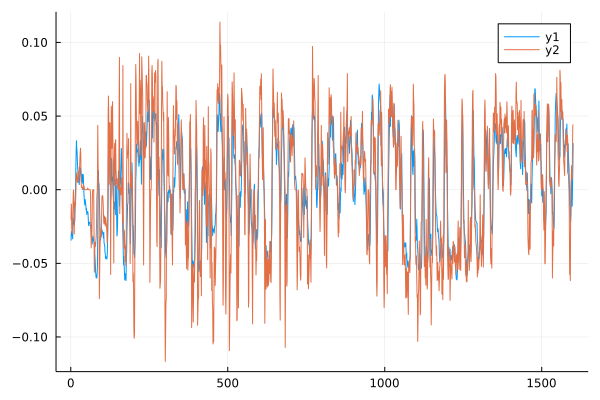

In [ ]:
let
    beh_idx = 1
    beh = decode_vars[beh_idx]
    println(beh)
    dsets_test = [dataset for dataset in datasets_baseline if !(dataset in analysis_dict["dsets_reg"])]
    println(mean([mean(analysis_dict["decoder_prediction_cost"][beh][dset][beh_idx,:]) for dset in dsets_test]))
    println(mean([mean(analysis_dict["decoder_prediction_quality"][beh][dset][beh_idx,:]) for dset in keys(analysis_dict["decoder_prediction_quality"][beh]) if dset in dsets_test]))
    Plots.plot(analysis_dict["decoder_prediction"][beh]["2021-05-26-07"][beh_idx,1,:])
    println(cost_mse(analysis_dict["decoder_prediction"][beh]["2021-05-26-07"][beh_idx,1,1:320], fit_results["2021-05-26-07"][beh]))
    Plots.plot!(fit_results["2021-05-26-07"][beh])
end

## Relative model performance plot (Figures 5A, 5C, 5H, and S17)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


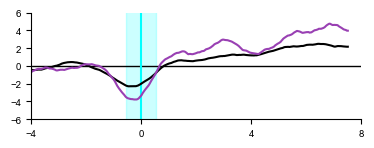

In [ ]:
let
    plot_static = true
    save_fig = false
    t_range = -8:0.01:8
    first_idx = 1
    last_idx = length(t_range)
    for dsets = [datasets_baseline_1600] #[["2022-06-14-01"]]#[[dataset] for dataset in datasets_stim_all]
        Δ = (length(dsets) == 1) ? 200 : 100

        if dsets == datasets_stim_all || dsets == datasets_stim_1600
            ec_prev = 290 - Δ÷2
            ec_post = 974 - Δ÷2
        elseif length(dsets) == 1
            ec_prev = fit_results[dsets[1]]["ranges"][1][end] - Δ÷2 - 101
            ec_post = fit_results[dsets[1]]["ranges"][end][end] - fit_results[dsets[1]]["ranges"][1][end] - Δ÷2
        else
            ec_prev = 699 - Δ÷2
            ec_post = 800 - Δ÷2
        end

        err_1_ec = zeros(length(t_range))
        err_2_ec = zeros(length(t_range))
        err_1_neuron = Dict()
        err_2_neuron = Dict()
        n_ec = 0
        err_1_static = zeros(length(t_range))
        err_2_static = zeros(length(t_range))
        n_static = 0
        err_1_nenc = zeros(length(t_range))
        err_2_nenc = zeros(length(t_range))
        n_nenc = 0

        @showprogress for dataset = dsets
            t1 = fit_results[dataset]["ranges"][1][end]-ec_prev
            t2 = fit_results[dataset]["ranges"][1][end]+ec_post
            Δ_rng = t1:t2



            for neuron in 1:fit_results[dataset]["num_neurons"]
                enc_1 = (neuron in analysis_dict["neuron_categorization"][dataset][1]["all"])
                enc_2 = (neuron in analysis_dict["neuron_categorization"][dataset][2]["all"])

                if !enc_1 && !enc_2
                    err_1 = err_1_nenc
                    err_2 = err_2_nenc
                    n_nenc += 1
                elseif neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"]
                    if neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["P"]["all"] &&
                        !(neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["v"]["all"]) &&
                        !(neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["θh"]["all"]) &&
                        !(neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["ewma_pos"]) &&
                        !(neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["ewma_neg"])
                        @warn("Pumping encoding change")
                        continue
                    end
                    err_1 = err_1_ec
                    err_2 = err_2_ec
                    n_ec += 1
                else
                    err_1 = err_1_static
                    err_2 = err_2_static
                    n_static += 1
                end

                ps1 = deepcopy(median(fit_results[dataset]["sampled_trace_params"][1,neuron,:,1:8], dims=1))
                rng_t = 1:1600
                max_t = 1600
                model1 = model_nl8(max_t, ps1..., fit_results[dataset]["v"][rng_t], fit_results[dataset]["θh"][rng_t], zeros(1600))
                ps2 = deepcopy(median(fit_results[dataset]["sampled_trace_params"][2,neuron,:,1:8], dims=1))
                ps2[6] = ps1[6]
                model2 = model_nl8(max_t, ps2..., fit_results[dataset]["v"][rng_t], fit_results[dataset]["θh"][rng_t], zeros(1600))

                err_1_n = zeros(ec_post+ec_prev+1)
                err_2_n = zeros(ec_post+ec_prev+1)

                for t=Δ_rng
                    c1 = cost_mse(model1[t-Δ÷2:t+Δ÷2], fit_results[dataset]["trace_array"][neuron,t-Δ÷2:t+Δ÷2])
                    c2 = cost_mse(model2[t-Δ÷2:t+Δ÷2], fit_results[dataset]["trace_array"][neuron,t-Δ÷2:t+Δ÷2])
                    err_1_n[t-t1+1] += c1
                    err_2_n[t-t1+1] += c2
                end
                
                timestep = fit_results[dataset]["avg_timestep"] / 60
                offset = fit_results[dataset]["ranges"][1][end]
                intp1 = LinearInterpolation((Δ_rng .- offset) .* timestep, err_1_n)
                intp2 = LinearInterpolation((Δ_rng .- offset) .* timestep, err_2_n)
                
                err_1_t = zeros(length(t_range))
                err_2_t = zeros(length(t_range))
                
                for (i,t)=enumerate(t_range)
                    if t < (Δ_rng[1] - offset) * timestep
                        if i > first_idx
                            first_idx = i
                        end
                        continue
                    elseif t > (Δ_rng[end] - offset) * timestep  
                        if i < last_idx
                            last_idx = i
                        end
                        continue
                    end
                    err_1_t[i] = intp1.(t)
                    err_2_t[i] = intp2.(t)
                    err_1[i] += err_1_t[i]
                    err_2[i] += err_2_t[i]
                end
                
                
                err_1_neuron[neuron] = err_1_t
                err_2_neuron[neuron] = err_2_t
            end
        end
        Plots.plot()
        first_idx += 1
        last_idx -= 1


        if length(dsets) == 1
            dset = dsets[1]
            dataset = dset
            timestep = fit_results[dataset]["avg_timestep"] / 60
        else
            timestep = mean([fit_results[dataset]["avg_timestep"] / 60 for dataset = dsets])
        end
        
        x_rng = t_range
        
        if length(dsets) == 1
            x_rng = x_rng .+ fit_results[dataset]["ranges"][1][end] .* timestep
        end
        

        if dsets == ["2022-08-02-01"] && !plot_static
            PyPlot.figure(figsize=(3.5,1.5))
        else
            PyPlot.figure(figsize=(3.75,1.5))
        end
        PyPlot.axhline(0, color="k", linewidth=1)

        if dsets == datasets_stim_all || dsets == datasets_stim_1600
            fill_between([-Δ÷2*timestep,Δ÷2*timestep],-7,7,color="red", alpha=0.2)
        end
        
        if dsets == datasets_stim_all
            PyPlot.ylim(-7,7)
            PyPlot.yticks(-7:7:7)
        elseif dsets == datasets_stim_1600
            PyPlot.ylim(-3,3)
            PyPlot.yticks(-3:1:3)
        elseif dsets == datasets_baseline_1600
            PyPlot.ylim(-6,6)
            PyPlot.yticks(-6:2:6)
            fill_between([-Δ÷2*timestep,Δ÷2*timestep],-7,7,color="cyan", alpha=0.2)
        elseif dsets == ["2022-04-05-01"]
            PyPlot.ylim(-4,6)
            PyPlot.yticks(-4:2:6)
        elseif dsets == ["2022-01-17-01"]
            PyPlot.ylim(-4,4)
            PyPlot.yticks(-4:2:4)
        elseif dsets == ["2022-08-02-01"]
            PyPlot.ylim(-6,4)
            PyPlot.yticks(-6:2:4)
        end
        if length(dsets) > 1
            PyPlot.xlim(-4,8)
            PyPlot.xticks(-4:4:8)
        elseif dsets == ["2022-01-17-01"]
            PyPlot.xlim(0,20)
            PyPlot.xticks(0:4:20)
        else
            PyPlot.xlim(0,16)
            PyPlot.xticks(0:4:16)
        end
        
        if dsets[1] in keys(manual_hypothesized_state_changes)
            PyPlot.axvline(manual_hypothesized_state_changes[dsets[1]], color="yellow", linestyle="--")
        end
        
        if length(dsets) == 1
            PyPlot.axvline(timestep * fit_results[dataset]["ranges"][1][end], c=(dataset in datasets_stim_all) ? "red" : "cyan")
        elseif dsets == datasets_stim_all || dsets == datasets_stim_1600
            PyPlot.axvline(0, c="red")
        else
            PyPlot.axvline(0, c="cyan")
        end
        
        if plot_static
            PyPlot.plot(x_rng[first_idx:last_idx], 5 .* (err_1_static[first_idx:last_idx] .- err_2_static[first_idx:last_idx]) ./ n_static, c="k")
        end
        
        PyPlot.plot(x_rng[first_idx:last_idx], 5 .* (err_1_ec[first_idx:last_idx] .- err_2_ec[first_idx:last_idx]) ./ n_ec, c=(0.6,0.25,0.7,1))

        fix_plot()
        tight_layout()


        if save_fig
            if plot_static && length(dsets) == 1
                create_dir(joinpath(path_fig_root, "figureS6"))
                path_dir = joinpath(path_fig_root, "figureS6/ec_examples")
            elseif length(dsets) == 1
                create_dir(joinpath(path_fig_root, "figureS7"))
                path_dir = joinpath(path_fig_root, "figureS7/ec_examples")
            else
                path_dir = joinpath(path_fig_root, "figureS7")
            end
            create_dir(path_dir)

            if length(dsets) == 1
                PyPlot.savefig(joinpath(path_dir, "$(dataset).png"))
                PyPlot.savefig(joinpath(path_dir, "$(dataset).pdf"))
                PyPlot.savefig(joinpath(path_dir, "$(dataset).svg"))
            elseif dsets == datasets_stim_all
                PyPlot.savefig(joinpath(path_dir, "heatstim.png"))
                PyPlot.savefig(joinpath(path_dir, "heatstim.pdf"))
                PyPlot.savefig(joinpath(path_dir, "heatstim.svg"))
            elseif dsets == datasets_stim_1600
                PyPlot.savefig(joinpath(path_dir, "heatstim_1600.png"))
                PyPlot.savefig(joinpath(path_dir, "heatstim_1600.pdf"))
                PyPlot.savefig(joinpath(path_dir, "heatstim_1600.svg"))
            elseif dsets == datasets_baseline_1600
                PyPlot.savefig(joinpath(path_dir, "baseline_1600.png"))
                PyPlot.savefig(joinpath(path_dir, "baseline_1600.pdf"))
                PyPlot.savefig(joinpath(path_dir, "baseline_1600.svg"))
            elseif dsets == datasets_baseline_merged 
                PyPlot.savefig(joinpath(path_dir, "baseline_merged.png"))
                PyPlot.savefig(joinpath(path_dir, "baseline_merged.pdf"))
                PyPlot.savefig(joinpath(path_dir, "baseline_merged.svg"))
            else
                error("unknown dataset type")
            end
        end
    end
end

## Encoding change type analysis (Figure S?)

359
[0.24233983286908078, 0.09192200557103064, 0.1894150417827298, 0.052924791086350974, 0.08635097493036212, 0.3370473537604457]


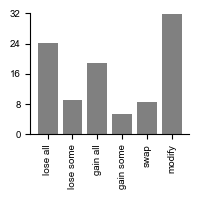

In [ ]:
let
    all = 0
    gain_beh = 0
    gain_all_beh = 0
    lose_beh = 0
    lose_all_beh = 0
    swap_beh = 0
    same_beh = 0
    for dataset = datasets_baseline
        for neuron in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"]
            behs_1 = [0,0,0]
            behs_2 = [0,0,0]
            for (i,beh) in enumerate(["v", "θh", "P"])
                if neuron in analysis_dict["neuron_categorization"][dataset][1][beh]["all"]
                    behs_1[i] += 1
                end
                if neuron in analysis_dict["neuron_categorization"][dataset][2][beh]["all"]
                    behs_2[i] += 1
                end
            end
            if sum(behs_1) == 0 && sum(behs_2) == 0
                error("Impossible encoding change in nonencoding neuron")
            end
            if sum(behs_1) == 0
                gain_all_beh += 1
            end
            if sum(behs_2) == 0
                lose_all_beh += 1
            end
            gain = false
            lose = false
            for i=1:3
                if behs_2[i] > behs_1[i] 
                    gain = true
                elseif behs_2[i] < behs_1[i]
                    lose = true
                end
            end
            if gain
                gain_beh += 1
            end
            if lose
                lose_beh += 1
            end
            if gain && lose
                swap_beh += 1
            end
            if !(gain || lose)
                same_beh += 1
            end
            all += 1
        end
    end
    println(all)
    PyPlot.figure(figsize=(2,2))
    PyPlot.bar(1:6, 100 .* [lose_all_beh, (lose_beh - lose_all_beh - swap_beh), gain_all_beh, (gain_beh - gain_all_beh - swap_beh), swap_beh, same_beh] ./ all, color="gray")
    
    println([lose_all_beh, (lose_beh - lose_all_beh - swap_beh), gain_all_beh, (gain_beh - gain_all_beh - swap_beh), swap_beh, same_beh] ./ all)
    PyPlot.xticks(1:6, ["lose all", "lose some", "gain all", "gain some", "swap", "modify"], rotation=90)
    PyPlot.ylim(0,32)
    PyPlot.yticks(0:8:32)
    
    fix_plot()
    tight_layout()
    
    PyPlot.savefig(joinpath(path_fig_root, "figure6/ec_type_freq.pdf"))
    
end

## Encoding change connectome analysis

Check if there is a difference in fraction of encoding changes depending on sensorimotor layer

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


inter: 0.698
inter: 0.303
motor: 0.561
motor: 0.44
sensory: 0.295
sensory: 0.705


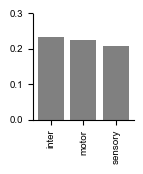

(Dict{Any, Any}("I5" => NaN, "RID" => 0.16666666666666666, "SAADR" => 0.5, "SMBD" => 0.0, "ASH" => 0.25, "I4" => NaN, "URYV" => 0.1724137931034483, "OLQD" => 0.35294117647058826, "RIR" => 0.0, "RMD" => 0.3333333333333333…), Dict{Any, Any}("I5" => 0, "RID" => 18, "SAADR" => 4, "SMBD" => 14, "ASH" => 8, "I4" => 0, "URYV" => 29, "OLQD" => 34, "RIR" => 3, "RMD" => 24…), Dict{Any, Any}("I5" => 0.0, "RID" => 1.0, "SAADR" => 0.6666666666666666, "SMBD" => 1.0, "ASH" => 0.47058823529411764, "I4" => 0.0, "URYV" => 0.8285714285714286, "OLQD" => 0.85, "RIR" => 1.0, "RMD" => 0.6486486486486487…))

In [ ]:
neuron_ec_ratios, tot_enc, enc_ratios = let
    neuron_types = Dict()
    types = ["inter", "motor", "sensory", "pharyngeal"]
    neuron_types["inter"] = String[]
    neuron_types["motor"] = String[]
    neuron_types["sensory"] = String[]
    neuron_types["pharyngeal"] = String[]

    inter_motor_sensory = String[]
    curr_type = "inter"
    for (i, neuron) = enumerate(analysis_dict["list_class_dv_ordered"])
        if neuron == "RMD" && curr_type == "inter"
            curr_type = "motor"
        elseif neuron == "ASJ" && curr_type == "motor"
            curr_type = "sensory"
        elseif neuron == "I1" && curr_type == "sensory"
            curr_type = "pharyngeal"
        end
        if curr_type in ["inter", "motor", "sensory"]
            push!(inter_motor_sensory, neuron)
        end
        push!(neuron_types[curr_type], neuron)
    end

    neuron_types["pharyngeal"]
    neuron_enc = Dict()
    neuron_ec = Dict()
    neuron_ratios = Dict()
    enc_ratios = Dict()
    t_enc = Dict()
    n_shuffle = 1000
    ratios = [Dict() for i=1:n_shuffle+1]
    @showprogress for i=1:n_shuffle+1
        ratio = ratios[i]
        for type = types
            neuron_enc[type] = 0
            neuron_ec[type] = 0
            dist = (i == n_shuffle + 1) ? neuron_types[type] : sample(inter_motor_sensory, length(neuron_types[type]), replace=false)
            for neuron in dist
                n_ec = 0
                n_enc = 0
                n_tot = 0
                for (dataset, n) in analysis_dict["matches"][neuron]
                    if !(dataset in datasets_neuropal_baseline)
                        continue
                    end
                    if n in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"]
                        n_ec += 1
                    end
                    if n in analysis_dict["neuron_categorization"][dataset][1]["all"] || n in analysis_dict["neuron_categorization"][dataset][2]["all"]
                        n_enc += 1
                    end
                    n_tot += 1
                end
                neuron_ratios[neuron] = n_ec / n_enc
                enc_ratios[neuron] = n_enc / n_tot
                t_enc[neuron] = n_enc
                neuron_ec[type] += n_ec
                neuron_enc[type] += n_enc
            end
            ratio[type] = neuron_ec[type] / neuron_enc[type]
        end
    end
    figure(figsize=(1.5,1.75))
    PyPlot.bar(1:3, [ratios[end][type] for type in types[1:3]], color="grey")
    for type in types[1:3]
        println("$type: $(mean([ratios[end][type] >= ratios[i][type] for i=1:n_shuffle]))")
        println("$type: $(mean([ratios[end][type] <= ratios[i][type] for i=1:n_shuffle]))")
    end
    PyPlot.xticks(1:3, types[1:3], rotation=90)
    PyPlot.ylim(0,0.3)
    fix_plot()
    tight_layout()

    neuron_ratios, t_enc, enc_ratios
end

Check if encoding changing neurons are more connected to each other than would be expected by chance

0.2727272727272727
["OLQD", "RMD", "AWA", "IL1D", "URYD", "ADL", "RIC", "IL1V", "RMDV", "RIA", "RMDD", "AVJ", "CEPD", "AIZ", "AIY", "URB", "AWC", "RME"]
["RID", "SMBD", "ASH", "URYV", "OLQD", "RMD", "M5", "AWA", "SAAV", "SMDD", "IL2V", "AWB", "RIS", "RIH", "RIV", "IL1D", "RIB", "OLL", "AVL", "IL1", "AVA", "AVB", "AVK", "IL2", "RMED", "URYD", "AVE", "AIN", "AIB", "ADL", "SMDV", "RMF", "RIC", "OLQV", "IL1V", "SMBV", "RMDV", "M3", "RIA", "RMEV", "MC", "RMDD", "AVJ", "I2", "MI", "SAAD", "AUA", "ASE", "BAG", "ASG", "CEPD", "AIZ", "RIM", "AVD", "AIY", "URB", "AWC", "VB2", "RME", "URX", "AQR", "CEPV", "FLP", "AIM"]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


0.3349025276977197
0.0021


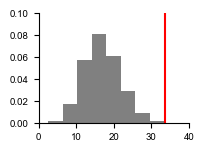

In [ ]:
let
    min_detections = 5
    min_ec = 0
    min_ec_frac = 0.25
    key_ec = "matches_ec_nomse"

    neurons_check = [x for x in keys(analysis_dict[key_ec]) if length(analysis_dict["matches"][x]) >= min_detections && tot_enc[x] >= min_detections]

    neurons_highec = [x for x in keys(analysis_dict[key_ec]) if length(analysis_dict["matches"][x]) >= min_detections && tot_enc[x] >= min_detections &&
            neuron_ec_ratios[x] >= min_ec_frac && analysis_dict["variability_baselineonly"][x] > 1]

    println(length(neurons_highec) / length(neurons_check))


    g = get_graph_white(1, merge_lr=true)
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]

    list_node_select_ = neurons_highec

    list_node_sample = String[]
    for node = neurons_check
        if node ∈ list_neuron_lr
            push!(list_node_sample, node[1:end-1])
        else
            push!(list_node_sample, node)
        end
    end

    list_node_sample = collect(map(correct_name, unique(list_node_sample)))

    list_node_select = String[]
    for node = list_node_select_
        if node ∈ list_neuron_lr
            push!(list_node_select, node[1:end-1])
        else
            push!(list_node_select, node)
        end
    end

    list_node_select = collect(map(correct_name, unique(list_node_select)))


    println(list_node_select)
    println(list_node_sample)

    n_trial = 10000

    intra_frac, list_rand_frac_intra= test_inter_conenctivity_intra_frac(g, list_node_select,
        list_node_sample=list_node_sample, n_trial=n_trial)

    println(intra_frac)
    p = sum(intra_frac .< list_rand_frac_intra) / n_trial
    println(p)
    
    figure(figsize=(2,1.5))
    hist(100 .* list_rand_frac_intra, density=true, color="gray")
    axvline(100*intra_frac, color="r")
    fix_plot()
    tight_layout()
    PyPlot.ylim(0,0.1)
    PyPlot.xlim(0,40)

    create_dir(joinpath(path_fig_root, "figure6"))

    PyPlot.savefig(joinpath(path_fig_root, "figure6", "ec_connectivity.pdf"), transparent=true)
end

## Encoding change correlation analysis (Figure S6)

In [ ]:
k_order, ec_together, clusts, clusts_k, clust_scores, k_scores, shuffled_matches_ec = let
    min_detections = 11
    min_ec = 0
    min_ec_frac = 0.1
    key_ec = "matches_ec_nomse"
    neurons_check = [x for x in keys(analysis_dict[key_ec]) if length(analysis_dict[key_ec][x]) >= min_ec && length(analysis_dict["matches"][x]) >= min_detections && 
            length(unique([y[1] for y in analysis_dict[key_ec][x]])) / length(analysis_dict["matches"][x]) >= min_ec_frac && analysis_dict["variability"][x] > 1]
    k_max = length(neurons_check)
    n_ec_neuropal = length(neurons_check)
    ec_together = zeros(n_ec_neuropal, n_ec_neuropal)
    k_order = enumerate(neurons_check)

    # Randomly shuffle encoding change datasets
    n_random_sample = 1000
    shuffled_matches_ec = [Dict() for i=1:n_random_sample+1]
    for i=1:n_random_sample+1
        for neuron in neurons_check
            datasets_detected = deepcopy(analysis_dict["matches"][neuron])
            encoding_changes = analysis_dict[key_ec][neuron]
            if i > 1
                shuffle!(datasets_detected)
                shuffled_matches_ec[i][neuron] = datasets_detected[1:length(encoding_changes)]
            else
                shuffled_matches_ec[i][neuron] = encoding_changes
            end
        end
    end
    ec_together = zeros(n_ec_neuropal, n_ec_neuropal, n_random_sample+1)
    clusts = []
    clusts_k = Dict()
    scores = zeros(k_max, n_random_sample+1)
    scores_k = zeros(k_max, n_random_sample+1)

    @showprogress for idx = 1:n_random_sample+1
        for (i,n1) in k_order
            for (j,n2) in k_order
                if i == j
                    ec_together[i,j,idx] = 1
                    continue
                elseif i > j
                    continue
                end
                datasets_1 = [x[1] for x in analysis_dict["matches"][n1]]
                datasets_2 = [x[1] for x in analysis_dict["matches"][n2]]
                datasets_both = intersect(datasets_1, datasets_2)

                ec_dict_1 = Dict()

                for (dataset1, n1_) in analysis_dict["matches"][n1]
                    if !(dataset1 in datasets_both)
                        continue
                    end
                    if dataset1 in keys(ec_dict_1)
                        push!(ec_dict_1[dataset1], (dataset1, n1_) in shuffled_matches_ec[idx][n1])
                    else
                        ec_dict_1[dataset1] = [(dataset1, n1_) in shuffled_matches_ec[idx][n1]]
                    end
                end

                ec_dict_2 = Dict()

                for (dataset2, n2_) in analysis_dict["matches"][n2]
                    if !(dataset2 in datasets_both)
                        continue
                    end
                    if dataset2 in keys(ec_dict_2)
                        push!(ec_dict_2[dataset2], (dataset2, n2_) in shuffled_matches_ec[idx][n2])
                    else
                        ec_dict_2[dataset2] = [(dataset2, n2_) in shuffled_matches_ec[idx][n2]]
                    end
                end

                ec_dot = 0
                ec_1 = 0
                ec_2 = 0
                for dataset = datasets_both
                    ec_dot += mean(ec_dict_1[dataset]) * mean(ec_dict_2[dataset])
                    ec_1 += mean(ec_dict_1[dataset])^2
                    ec_2 += mean(ec_dict_2[dataset])^2
                end

                ec_together[i,j,idx] = 2 * ec_dot / (ec_1 + ec_2)
                ec_together[j,i,idx] = ec_together[i,j,idx]
            end
        end
        ec_together_nonan = collect(map(x->(isnan(x) ? 0.0 : x), ec_together[:,:,idx]))
        distance_matrix = 1.0 .- ec_together_nonan

        clust = hclust(distance_matrix, linkage=:ward)
        push!(clusts, clust)

        for k=2:k_max
            if haskey(clusts_k, k)
                push!(clusts_k[k], kmeans(ec_together_nonan, k))
            else
                clusts_k[k] = [kmeans(ec_together_nonan, k)]
            end
            cut_tree = cutree(clust, k=k) # Assigns each data point to a cluster (1 to k)

            # Compute the silhouette scores
            silhouettes = Clustering.silhouettes(cut_tree, distance_matrix)
            silhouette_score = mean(silhouettes)
            scores[k, idx] = silhouette_score

            kmeans_dm = pairwise(SqEuclidean(), ec_together_nonan, ec_together_nonan)
            kmeans_assignments = assignments(clusts_k[k][end])
            kmeans_silhouettes = Clustering.silhouettes(kmeans_assignments, kmeans_dm)
            scores_k[k, idx] = mean(kmeans_silhouettes)
        end
    end
    k_order, ec_together, clusts, clusts_k, scores, scores_k, shuffled_matches_ec
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


(enumerate(["URYV", "OLQD", "RMD", "M5", "SMDD", "IL1D", "ASI", "OLL", "AVL", "IL1L"  …  "RMDD", "AUA", "IL2L", "AIZ", "AIA", "AIY", "URB", "RME", "URX", "CEPV"]), [1.0 0.5365853658536586 … 0.42857142857142855 0.42424242424242425; 0.5365853658536586 1.0 … 0.6 0.358974358974359; … ; 0.42857142857142855 0.6 … 1.0 0.14285714285714285; 0.42424242424242425 0.358974358974359 … 0.14285714285714285 1.0;;; 1.0 0.43902439024390244 … 0.041666666666666664 0.5185185185185185; 0.43902439024390244 1.0 … 0.375 0.06451612903225806; … ; 0.041666666666666664 0.375 … 1.0 0.0; 0.5185185185185185 0.06451612903225806 … 0.0 1.0;;; 1.0 0.2857142857142857 … 0.1276595744680851 0.05405405405405406; 0.2857142857142857 1.0 … 0.32558139534883723 0.10810810810810811; … ; 0.1276595744680851 0.32558139534883723 … 1.0 0.25806451612903225; 0.05405405405405406 0.10810810810810811 … 0.25806451612903225 1.0;;; … ;;; 1.0 0.16326530612244897 … 0.13636363636363635 0.2926829268292683; 0.16326530612244897 1.0 … 0.448979591836734

Plot matrix of neurons that encoding change together

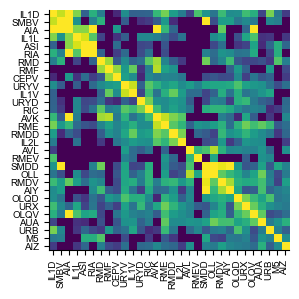

In [ ]:
let
    save_fig = false
    idx = 1 # 1 for real data, other numbers for simulations
    clust = clusts[idx]
    PyPlot.figure(figsize=(3,3))
    PyPlot.imshow(ec_together[clust.order, clust.order, idx], cmap=:viridis, vmax=0.75)
    n_ec_neuropal = size(ec_together,1)
    PyPlot.yticks(0:n_ec_neuropal-1, [k[2] for k in collect(k_order)[clust.order]])
    PyPlot.xticks(0:n_ec_neuropal-1, [k[2] for k in collect(k_order)[clust.order]], rotation=90)
    fix_plot()
    tight_layout()
    if save_fig
        create_dir(joinpath(path_fig_root, "figure6"))
        PyPlot.savefig(joinpath(path_fig_root, "figure6", "ec_together.pdf"), transparent=true)
    end
end

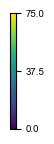

In [ ]:
plot_colorbar(0, 75, [37.5], :viridis, 256, (0.75, 1.5))
# fix_plot()
# PyPlot.savefig(joinpath(path_fig_root, "figure6/ec_together_colorbar.pdf"), bbox_inches="tight", transparent=true)

Are the encoding-changing-together neurons more clusxtered than would be expected by chance?

99.6


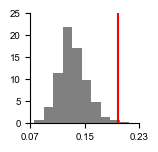

(PyObject[PyObject <matplotlib.axis.YTick object at 0x7f726ea8d9f0>, PyObject <matplotlib.axis.YTick object at 0x7f726ea8d390>, PyObject <matplotlib.axis.YTick object at 0x7f726eaae6b0>, PyObject <matplotlib.axis.YTick object at 0x7f726eaaec20>, PyObject <matplotlib.axis.YTick object at 0x7f726eaafa90>, PyObject <matplotlib.axis.YTick object at 0x7f726eaaea40>], PyObject[PyObject Text(0, 0, '0'), PyObject Text(0, 5, '5'), PyObject Text(0, 10, '10'), PyObject Text(0, 15, '15'), PyObject Text(0, 20, '20'), PyObject Text(0, 25, '25')])

In [ ]:
let
    k = 3
    println(100 * (1 - sum(clust_scores[k,2:end] .> clust_scores[k,1]) / length(clust_scores[k,2:end])))
    PyPlot.figure(figsize=(1.5,1.5))
    PyPlot.hist(clust_scores[k,2:end], color="grey", density=true)
    PyPlot.axvline(clust_scores[k,1], color="red")
    fix_plot()
    tight_layout()
    PyPlot.xlim(0.07, 0.23)
    PyPlot.xticks(0.07:0.08:0.23)
    PyPlot.yticks(0:5:25)
end

Check if an arbitrary set of neurons are more connected together than would be expected by chance. Change `list_neuron_lr` to check a different group.

["RID", "URYV", "OLQD", "SAAV", "RIS", "SMDD", "RIV", "ASI", "RIB", "OLL", "AVL", "IL1", "AVA", "AVK", "RMED", "URYD", "AVE", "AIN", "AIB", "SMDV", "RIC", "RMF", "OLQV", "IL1V", "RMDV", "RIA", "RMDD", "AUA", "ASG", "IL2", "AIZ", "RIM", "AIA", "AIY", "VB2", "RME", "URAD", "URX", "CEPV", "AIM"]
["RID", "SAAD", "ASH", "URYV", "OLQD", "RMD", "M5", "AWA", "SAAV", "ADA", "RIS", "SMDD", "IL2V", "AWB", "RIH", "RIV", "IL1D", "ASI", "M1", "RIB", "OLL", "AVL", "IL1", "AVA", "IL2D", "AVB", "AVK", "IL2", "RMED", "URYD", "AVE", "AIN", "AIB", "ADL", "SMDV", "RIC", "RMF", "RMG", "OLQV", "IL1V", "RMDV", "I6", "M3", "RMEV", "MC", "RIA", "RMDD", "AVJ", "I2", "MI", "AUA", "I1", "ASE", "I3", "BAG", "ASG", "CEPD", "AIZ", "RIM", "AVD", "AIA", "AIY", "URB", "AWC", "VB2", "RME", "URAD", "URX", "ADE", "M4", "AQR", "CEPV", "URAV", "FLP", "NSM", "AIM", "AVH"]


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


0.519298911537256
0.0


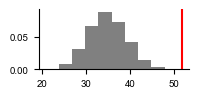

In [ ]:
let
    g = get_graph_white(1, merge_lr=true)
    list_neuron_lr = ["SAADL","SAADR","IL1L","IL1R","IL2L","IL2R","ASEL","ASER"]
    


    order = [collect(k_order)[i][2] for i=1:length(k_order)]
    clust1_hier = order[cutree(clusts[1], k=2) .== 1]

    list_node_select_ = clust1_hier

    list_node_sample = String[]
    for node = collect(keys(analysis_dict["matches"]))
        if length(analysis_dict["matches"][node]) < 11
            continue
        end
        if node ∈ list_neuron_lr
            push!(list_node_sample, node[1:end-1])
        else
            push!(list_node_sample, node)
        end
    end

    list_node_sample = collect(map(correct_name, unique(list_node_sample)))

    list_node_select = String[]
    for node = list_node_select_
        if node ∈ list_neuron_lr
            push!(list_node_select, node[1:end-1])
        else
            push!(list_node_select, node)
        end
    end

    list_node_select = collect(map(correct_name, unique(list_node_select)))


    println(list_node_select)
    println(list_node_sample)

    high_var_threshold = 1.95
    n_trial = 10000
    
    intra_frac, list_rand_frac_intra= test_inter_conenctivity_intra_frac(g, list_node_select,
        list_node_sample=list_node_sample, n_trial=n_trial)

    println(intra_frac)
    println(sum(intra_frac .< list_rand_frac_intra) / n_trial)
    
    figure(figsize=(2,1))
    hist(100 .* list_rand_frac_intra, density=true, color="gray")
    axvline(100*intra_frac, color="r")

    fix_plot()
    tight_layout()
end

## Variability comparison analysis

Compare different definitions of variability against each other, depending on `plot_type`:

- `plot_type = 'baseline_vs_stim'`: plot baseline variability vs variability in the heat-stim datasets. Figure 6A.
- `plot_type = 'var_comparison'`: plot inter-dataset variability vs intra-dataset variability. Figure S7H
- `plot_type = 'var_vs_ec_ratio'`: plot variability vs fraction of encodings that change for a given neuron. Figure S6C.

OLQD
0.35294117647058826
2.6113273691422663
RIH
0.1111111111111111
0.9455840505110761
IL1D
0.34782608695652173
2.1404704047345287
OLL
0.15384615384615385
2.274201293259072
OLQV
0.12
2.580016486536352
URB
0.4444444444444444
1.8351763059627029
URX
0.21739130434782608
1.995050856125917
CEPV
0.11764705882352941
1.8379373404328323
Correlation: 0.2935700563621366


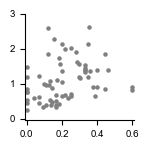

Test for nonzero correlation
----------------------------
Population details:
    parameter of interest:   Correlation
    value under h_0:         0.0
    point estimate:          0.29357
    95% confidence interval: (0.05548, 0.5001)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0167

Details:
    number of observations:          66
    number of conditional variables: 0
    t-statistic:                     2.45681
    degrees of freedom:              64


In [ ]:
let
    plot_type = "var_vs_ec_ratio"

    intra = Float64[]
    intra_sig = Float64[]
    inter = Float64[]
    tot = Float64[]
    ec = Float64[]
    ec_ratio = Float64[]

    ec_dict = Dict()

    intra_stim = Float64[]
    intra_sig_stim = Float64[]
    inter_stim = Float64[]
    tot_stim = Float64[]
    ec_stim = Float64[]
    ec_ratio_stim = Float64[]

    ec_dict_stim = Dict()

    ec_key = "matches_ec_nomse"

    min_detections = 5

    for var_suffix = ["_baselineonly", "_stimonly"]
        intra_ = Float64[]
        intra_sig_ = Float64[]
        inter_ = Float64[]
        tot_ = Float64[]
        ec_ = Float64[]
        ec_ratio_ = Float64[]

        ec_dict_ = Dict()
        ec_key = "matches_ec_nomse"

        if var_suffix == "_baselineonly"
            datasets_use = datasets_neuropal_baseline
        else
            datasets_use = datasets_neuropal_stim
        end

        datasets_notuse = [x for x in datasets_neuropal if !(x in datasets_use)]

        for neuron = keys(analysis_dict["matches"])
            if !(neuron in keys(analysis_dict["intra_variability$var_suffix"])) || isnan(analysis_dict["intra_variability$var_suffix"][neuron]) || 
                    length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_use]) < min_detections || (plot_type == "baseline_vs_stim" && length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_notuse]) < min_detections)
                continue
            end

            ec_num = 0
            enc_num = 0
            if neuron in keys(analysis_dict[ec_key])
                for (dataset, n) = analysis_dict[ec_key][neuron]
                    if !(dataset in datasets_use)
                        continue
                    end
                    rngs = (1,2)
                    ec_num += 1
                end
            end

            for (dataset, n) = analysis_dict["matches"][neuron]
                if !(dataset in datasets_use)
                    continue
                end

                if (n in analysis_dict["neuron_categorization"][dataset][1]["all"]) || (n in analysis_dict["neuron_categorization"][dataset][2]["all"])
                    enc_num += 1
                end
            end
            if plot_type == "var_vs_ec_ratio" && enc_num < min_detections
                continue
            end
            push!(intra_, analysis_dict["intra_variability$var_suffix"][neuron])
            push!(inter_, analysis_dict["inter_variability$var_suffix"][neuron])
            push!(tot_, analysis_dict["variability$var_suffix"][neuron])

            push!(ec_ratio_, ec_num / enc_num)
            if neuron in ["OLQD", "IL1D", "CEPV", "OLL", "URB", "URX", "RIH", "OLQV"] && var_suffix == "_baselineonly"
                println(neuron)
                println(ec_num / enc_num)
                println(analysis_dict["variability$var_suffix"][neuron])
            end
            push!(ec_, ec_num / length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_use]))
            ec_dict_[neuron] = ec_num / length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_use])
            push!(intra_sig_, analysis_dict["intra_variability$var_suffix"][neuron] * ec_dict_[neuron])
        end
        if var_suffix == "_baselineonly"
            intra = intra_
            intra_sig = intra_sig_
            inter = inter_
            tot = tot_
            ec = ec_
            ec_dict = ec_dict_
            ec_ratio = ec_ratio_
        else
            intra_stim = intra_
            intra_sig_stim = intra_sig_
            inter_stim = inter_
            tot_stim = tot_
            ec_stim = ec_
            ec_dict_stim = ec_dict_
            ec_ratio_stim = ec_ratio_
        end
    end



    if plot_type == "baseline_vs_stim"
        figure(figsize=(1.5,1.5))
        PyPlot.plot(0:2, 0:2, color="black", linewidth=0.5)
        PyPlot.scatter(intra, intra_stim, s=5, color="grey")
        PyPlot.ylim(-0.1,3)
        PyPlot.xlim(-0.1,2)
        fix_plot()
        tight_layout()
        create_dir(joinpath(path_fig_root, "figureS7"))
        PyPlot.savefig(joinpath(path_fig_root, "figureS7", "baseline_vs_stim_intra.pdf"))
    elseif plot_type == "var_comparison"
        figure(figsize=(1.5,1.5))
        PyPlot.plot(0:2, 0:2, color="black", linewidth=0.5)
        PyPlot.scatter(intra, inter, s=5, color="grey")
        PyPlot.ylim(0,3)
        PyPlot.xlim(0,2)
        fix_plot()
        tight_layout()
        create_dir(joinpath(path_fig_root, "figureS6"))
        PyPlot.savefig(joinpath(path_fig_root, "figureS6", "intra_vs_inter.pdf"))
    elseif plot_type == "var_vs_ec_ratio"
        figure(figsize=(1.5,1.5))

        PyPlot.scatter(ec_ratio, tot, s=5, color="grey")

        PyPlot.xlim(-0.01,0.61)
        PyPlot.xticks(0:0.2:0.6)
        PyPlot.ylim(-0.05,3.0)

        fix_plot()
        tight_layout()
        create_dir(joinpath(path_fig_root, "figure6"))

        println("Correlation: $(cor(ec_ratio, tot))")
        CorrelationTest(ec_ratio, tot)
        PyPlot.savefig(joinpath(path_fig_root, "figure6", "var_vs_ec_ratio.pdf"), transparent=true)
    end
end

## Left vs Right neuron analysis

In [ ]:
lr_correlation = Dict()

for neuron in keys(analysis_dict["matches"])
    matches = analysis_dict["matches"][neuron]
    lr_correlation[neuron] = Float64[]
    for dataset = unique([match[1] for match in matches])
        matches_dataset = [match for match in matches if match[1] == dataset]
        if length(matches_dataset) > 2
            @warn("more than two matches for neuron $neuron in dataset $dataset")
            continue
        end
        if length(matches_dataset) < 2
            continue
        end
        if dataset in datasets_neuropal_baseline
            push!(lr_correlation[neuron], cor(fit_results[dataset]["trace_array"][matches_dataset[1][2],:], fit_results[dataset]["trace_array"][matches_dataset[2][2],:]))
        else
            push!(lr_correlation[neuron], cor(fit_results[dataset]["trace_array"][matches_dataset[1][2],1:stim_times[dataset]-1], fit_results[dataset]["trace_array"][matches_dataset[2][2],1:stim_times[dataset]-1]))
        end
    end
end

analysis_dict["lr_correlation"] = lr_correlation;


┌ Warning: more than two matches for neuron URYD in dataset 2023-01-05-01
└ @ Main In[186]:9
┌ Warning: more than two matches for neuron IL2 in dataset 2023-01-16-01
└ @ Main In[186]:9
┌ Warning: more than two matches for neuron URAD in dataset 2023-01-23-15
└ @ Main In[186]:9


ASE: LR correlation -0.022290818106203543, number of detections 14
AIA: LR correlation -0.013325006714298523, number of detections 4
IL1: LR correlation -0.0071549333178209645, number of detections 30
SAAD: LR correlation 0.10757883240769213, number of detections 15
ADE: LR correlation 0.13413200522351898, number of detections 10
IL2: LR correlation 0.15700905171896679, number of detections 20
ADL: LR correlation 0.19895717790332984, number of detections 4
RIF: LR correlation 0.2311198451595443, number of detections 3
AWC: LR correlation 0.25000259787765855, number of detections 16
ASK: LR correlation 0.25352122227345775, number of detections 4
URB: LR correlation 0.26812918457761276, number of detections 21
FLP: LR correlation 0.29579730545983773, number of detections 13
AVJ: LR correlation 0.2999742657201664, number of detections 28
CEPD: LR correlation 0.3001530788918854, number of detections 30
SMDD: LR correlation 0.32032502646615896, number of detections 12
URAV: LR correlation 0

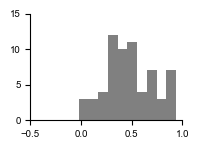

In [ ]:
let
    mean_lr_correlation = Dict()
    for neuron in keys(lr_correlation)
        if length(lr_correlation[neuron]) == 0
            continue
        end
        mean_lr_correlation[neuron] = mean(lr_correlation[neuron])
    end
    sorted_mean_lr_correlation = sort(collect(mean_lr_correlation), by=x->x[2])
    for (n, c) in sorted_mean_lr_correlation
        n_detections = length(lr_correlation[n])
        if n_detections < 2
            continue
        end
        println("$n: LR correlation $c, number of detections $n_detections")
    end

    PyPlot.figure(figsize=(2,1.5))
    PyPlot.hist([mean_lr_correlation[n] for n in keys(mean_lr_correlation) if length(lr_correlation[n]) > 1], bins=10, color="grey")
    PyPlot.xlim(-0.5,1.0)
    PyPlot.ylim(0,15)
    fix_plot()
    tight_layout()

    PyPlot.savefig(joinpath(path_fig_root, "figureS2/lr_correlation.pdf"))
end

## NeuroPAL vs baseline: behavior

0.3347767857142857
0.40270591733571215
0.5309375
0.6311626523936961
0.6841097602224335
0.7426933065471678


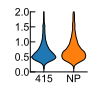

In [ ]:
let
    save_plot = true

    v_baseline = vcat([fit_results[dataset]["v"] for dataset in datasets_baseline]...)
    θh_baseline = vcat([fit_results[dataset]["θh"].* (1-2*θh_pos_is_ventral[dataset])  for dataset in datasets_baseline]...)
    P_baseline = vcat([fit_results[dataset]["P"] for dataset in datasets_baseline]...)
    ang_vel_baseline = vcat([fit_results[dataset]["ang_vel"] for dataset in datasets_baseline]...)
    curve_baseline = vcat([fit_results[dataset]["curve"] for dataset in datasets_baseline]...)

    v_neuropal_baseline = vcat([fit_results[dataset]["v"] for dataset in datasets_neuropal_baseline]...)
    θh_neuropal_baseline = vcat([fit_results[dataset]["θh"] .* (1-2*θh_pos_is_ventral[dataset]) for dataset in datasets_neuropal_baseline]...)
    P_neuropal_baseline = vcat([fit_results[dataset]["P"] for dataset in datasets_neuropal_baseline]...)
    ang_vel_neuropal_baseline = vcat([fit_results[dataset]["ang_vel"] for dataset in datasets_neuropal_baseline]...)
    curve_neuropal_baseline = vcat([fit_results[dataset]["curve"] for dataset in datasets_neuropal_baseline]...)

    println(sum(v_baseline .< 0) / length(v_baseline))
    println(sum(v_neuropal_baseline .< 0) / length(v_neuropal_baseline))

    println(sum(θh_baseline .< 0) / length(θh_baseline))
    println(sum(θh_neuropal_baseline .< 0) / length(θh_neuropal_baseline))

    println(mean(curve_baseline))
    println(mean(curve_neuropal_baseline))

    var_plot = "curve"

    if save_plot
        create_dir(joinpath(path_fig_root, "figureS5"))
        create_dir(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior"))
    end

    if var_plot == "v"
        violin(v_baseline, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(v_neuropal_baseline, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(-0.2,0.2)
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior/violin_v.pdf"))
        end
    elseif var_plot == "θh"
        violin(θh_baseline, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(θh_neuropal_baseline, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(-pi/2, pi/2)
        Plots.yticks!(-pi/2:pi/4:pi/2, ["-π/2", "-π/4", "0", "π/4", "π/2"])
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior/violin_θh.pdf"))
        end
    elseif var_plot == "P"
        violin(P_baseline, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(P_neuropal_baseline, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(0,5)
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior/violin_P.pdf"))
        end
    elseif var_plot == "ang_vel"
        violin(ang_vel_baseline, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(ang_vel_neuropal_baseline, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(-0.4,0.4)
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior/violin_ang_vel.pdf"))
        end
    elseif var_plot == "curve"
        violin(curve_baseline, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(curve_neuropal_baseline, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(0,2)
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior/violin_curve.pdf"))
        end
    end
    Plots.plot!()
end

Approximate Mann-Whitney U test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          -0.0606279

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           0.0071

Details:
    number of observations in each group: [25, 40]
    Mann-Whitney-U statistic:             300.0
    rank sums:                            [625.0, 1520.0]
    adjustment for ties:                  0.0
    normal approximation (μ, σ):          (-200.0, 74.162)



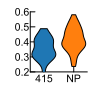

In [ ]:
let
    v_swf415 = Float64[]
    rev_frac_swf415 = Float64[]
    hc_swf415 = Float64[]
    P_swf415 = Float64[]
    for dataset = datasets_swf415
        if dataset in datasets_baseline
            push!(v_swf415, mean(fit_results[dataset]["v"]))
            push!(rev_frac_swf415, mean(fit_results[dataset]["v"] .< 0))
            push!(hc_swf415, mean(fit_results[dataset]["θh"]) * (1-2*θh_pos_is_ventral[dataset]))
            push!(P_swf415, mean(fit_results[dataset]["P"]))
        else
            push!(v_swf415, mean(fit_results[dataset]["v"][1:stim_times[dataset]-1]))
            push!(rev_frac_swf415, mean(fit_results[dataset]["v"][1:stim_times[dataset]-1] .< 0))
            push!(hc_swf415, mean(fit_results[dataset]["θh"][1:stim_times[dataset]-1]) * (1-2*θh_pos_is_ventral[dataset]))
            push!(P_swf415, mean(fit_results[dataset]["P"][1:stim_times[dataset]-1]))
        end
    end

    v_neuropal = Float64[]
    rev_frac_neuropal = Float64[]
    hc_neuropal = Float64[]
    P_neuropal = Float64[]

    for dataset = datasets_neuropal
        if dataset in datasets_neuropal_baseline
            push!(v_neuropal, mean(fit_results[dataset]["v"]))
            push!(rev_frac_neuropal, mean(fit_results[dataset]["v"] .< 0))
            push!(hc_neuropal, mean(fit_results[dataset]["θh"]) * (1-2*θh_pos_is_ventral[dataset]))
            push!(P_neuropal, mean(fit_results[dataset]["P"]))
        else
            push!(v_neuropal, mean(fit_results[dataset]["v"][1:stim_times[dataset]-1]))
            push!(rev_frac_neuropal, mean(fit_results[dataset]["v"][1:stim_times[dataset]-1] .< 0))
            push!(hc_neuropal, mean(fit_results[dataset]["θh"][1:stim_times[dataset]-1]) * (1-2*θh_pos_is_ventral[dataset]))
            push!(P_neuropal, mean(fit_results[dataset]["P"][1:stim_times[dataset]-1]))
        end
    end

    var_plot = "rev_frac"
    save_plot = true

    if save_plot
        create_dir(joinpath(path_fig_root, "figureS5"))
        create_dir(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior_peranimal"))
    end

    if var_plot == "v"
        violin(v_swf415, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(v_neuropal, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(-0.02,0.06)
        yticks!(-0.02:0.02:0.06)
        println(MannWhitneyUTest(v_swf415, v_neuropal))
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior_peranimal/violin_v.pdf"))
        end
    elseif var_plot == "hc"
        violin(hc_swf415, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(hc_neuropal, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(-0.6,0.2)
        yticks!(-0.6:0.2:0.2)
        println(MannWhitneyUTest(hc_swf415, hc_neuropal))
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior_peranimal/violin_hc.pdf"))
        end
    elseif var_plot == "P"
        violin(P_swf415, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(P_neuropal, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        println(MannWhitneyUTest(P_swf415, P_neuropal))
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior_peranimal/violin_P.pdf"))
        end
    elseif var_plot == "rev_frac"
        violin(rev_frac_swf415, color=palette(:tab10)[1], size=(100,100), label=nothing)
        violin!(rev_frac_neuropal, color=palette(:tab10)[2], label=nothing)
        xticks!(1:2, ["415", "NP"])
        Plots.ylims!(0.2,0.6)
        yticks!(0.2:0.1:0.6)
        println(MannWhitneyUTest(rev_frac_swf415, rev_frac_neuropal))
        if save_plot
            Plots.savefig(joinpath(path_fig_root, "figureS5/neuropal_vs_baseline_behavior_peranimal/violin_rev_frac.pdf"))
        end
    end
    Plots.plot!()
end


## Signal value analysis (encoding vs nonencoding)

95th percentile of GFP signal: 0.10656283924524693
Fraction of SWF415 neurons with signal: 0.9915084915084915
Fraction of NeuroPAL neurons with signal: 0.9886870071991772
Neuron RMG has a signal below the GFP threshold: 0.08627991375151217, 0.11762497804408965, 0.12731436488545414
Neuron RIA has a signal below the GFP threshold: 0.09309671397568856, 0.12000802949027362, 0.13185950952556322
Neuron CEPD has a signal below the GFP threshold: 0.08570013966539494, 0.11337265103283882, 0.12920247189045128
Neuron AIZ has a signal below the GFP threshold: 0.10455990398641929, 0.14648494290211894, 0.1702425653952404
Neuron AVD has a signal below the GFP threshold: 0.06654670266954399, 0.08596875202532085, 0.1185700799119781
Neuron ADE has a signal below the GFP threshold: 0.09995578277037662, 0.14087596825816803, 0.19301278329591304
Neuron CEPV has a signal below the GFP threshold: 0.09869227670563463, 0.12926868854475215, 0.1630954516083456
Neuron FLP has a signal below the GFP threshold: 0.07

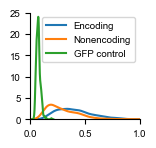

In [ ]:
let
    save_fig = false

    fig_type = "encoding" # set to "neuropal" to do SWF415 vs NeuroPAL comparison, or set to "encoding" to do encoding vs nonencoding comparison
    enc_signal = Float64[]
    nonenc_signal = Float64[]
    enc_neurons = get_all_neurons_with_feature(fit_results, analysis_dict, "all", nothing)[1]

    for dataset in datasets_baseline
        for neuron in 1:size(fit_results[dataset]["trace_array"],1)
            if neuron in enc_neurons[dataset]
                push!(enc_signal, analysis_dict["signal"][dataset][neuron])
            else
                push!(nonenc_signal, analysis_dict["signal"][dataset][neuron])
            end
        end
    end

    gfp_signal = Float64[]
    for dataset in datasets_gfp
        for neuron in 1:size(fit_results[dataset]["trace_array"],1)
            push!(gfp_signal, analysis_dict["signal"][dataset][neuron])
        end
    end

    neuropal_signal = Float64[]
    for dataset in datasets_neuropal_baseline
        for neuron in 1:size(fit_results[dataset]["trace_array"],1)
            push!(neuropal_signal, analysis_dict["signal"][dataset][neuron])
        end
    end

    swf415_signal = vcat(enc_signal, nonenc_signal)

    println("95th percentile of GFP signal: $(percentile(gfp_signal, 95))")
    gfp_perc = percentile(gfp_signal, 95)

    frac_signal = sum(swf415_signal .> gfp_perc) / length(swf415_signal)
    frac_neuropal_signal = sum(neuropal_signal .> gfp_perc) / length(neuropal_signal)
    println("Fraction of SWF415 neurons with signal: $frac_signal")
    println("Fraction of NeuroPAL neurons with signal: $frac_neuropal_signal")

    for neuron = keys(analysis_dict["signal_neuropal"])
        if percentile(analysis_dict["signal_neuropal"][neuron], 5) < gfp_perc
            println("Neuron $neuron has a signal below the GFP threshold: $(percentile(analysis_dict["signal_neuropal"][neuron], 5)), $(percentile(analysis_dict["signal_neuropal"][neuron], 25)), $(percentile(analysis_dict["signal_neuropal"][neuron], 50))")
        end
    end

    if fig_type == "neuropal"
        PyPlot.figure(figsize=(1.333,1))
    else
        PyPlot.figure(figsize=(1.6,1.5))
    end
    if fig_type == "encoding"
        PyPlot.plot(kde(enc_signal).x, kde(enc_signal).density, label="Encoding")
        PyPlot.plot(kde(nonenc_signal).x, kde(nonenc_signal).density, label="Nonencoding")
    elseif fig_type == "neuropal"
        PyPlot.plot(kde(swf415_signal).x, kde(swf415_signal).density, label="SWF415")
        PyPlot.plot(kde(neuropal_signal).x, kde(neuropal_signal).density, label="NeuroPAL")
    end

    PyPlot.plot(kde(gfp_signal).x, kde(gfp_signal).density, label="GFP control")
    xlim(0,1)
    ylim(0,25)
    if fig_type != "neuropal"
        legend()
    end
    fix_plot()
    tight_layout()

    if save_fig && fig_type == "encoding"
        save_dir = joinpath(path_fig_root, "figureS2")
        create_dir(save_dir)
        PyPlot.savefig(joinpath(save_dir, "signal_distribution_encoding.pdf"), transparent=true)
    elseif save_fig && fig_type == "neuropal"
        save_dir = joinpath(path_fig_root, "figureS5")
        create_dir(save_dir)
        PyPlot.savefig(joinpath(save_dir, "signal_distribution_neuropal.pdf"), transparent=true)
    end
end

## Plot sensory-responding, state, and encoding changing neurons

Change the `plot_type` argument to change what to plot. Options are:

- `plot_type = 'response_mtx_sensory'`: plot sensory-responding neurons. Part of Figure 7G.
- `plot_type = 'response_mtx_state'`: plot state neurons. Part of Figure 7G.
- `plot_type = 'response_mtx_ec'`: plot encoding changing neurons. Part of Figure 7G.
- `plot_type = 'neuron_consistency_ec_rand'`: plot consistency of encoding change in heat-stim animals. Figure S7G.
- `plot_type = 'connectome_sensory'`: plot where stim-responsive neurons are in the connectome. Figure S7C-D.

-0.05602033814740367
["AFD (1)", "SIBD (2)", "AWC (29)", "ASER (8)", "FLP (26)", "AWB (29)", "ADL (15)", "AWA (21)", "ASH (7)", "RMG (7)", "AVD (29)", "AVJ (33)", "ADA (14)", "M2 (1)", "NSM (34)", "I1 (37)", "AQR (5)", "M5 (13)", "RMED (3)", "RME (34)", "RIV (36)", "RIC (28)", "BAG (8)", "ALA (2)", "IL1L (16)", "RMF (8)", "RMD (20)", "VB02 (11)", "AIM (18)", "SAADR (4)", "IL2V (27)", "URX (30)", "SAAV (15)", "CEPD (36)", "URAV (9)", "IL2R (11)", "URAD (13)", "IL2D (33)", "RMEV (6)", "AIZ (33)", "RIA (20)", "AVE (27)", "URB (25)", "SMBV (8)", "AIY (17)", "RMDV (30)", "ASI (11)", "AVB (6)", "SMDD (16)", "URYV (31)", "URYD (28)", "SIAD (1)", "I6 (8)", "AIA (8)", "SMBD (6)", "SMDV (29)", "SIAV (9)", "RID (15)", "ASJ (2)", "SIBV (6)", "RIS (3)", "RIB (13)", "I5 (1)", "MC (18)", "AVK (9)", "M3 (35)", "M4 (14)", "OLL (33)", "IL1D (31)", "SAADL (3)", "RIR (4)", "AIN (25)", "IL2L (16)", "RIH (14)", "RMDD (29)", "ASEL (15)", "CEPV (28)", "OLQD (35)", "OLQV (30)", "I3 (19)", "IL1V (27)", "I2 (33)

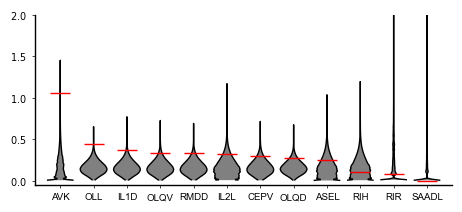

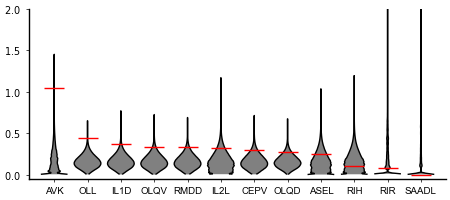

In [ ]:
let
    plot_type = "neuron_consistency_ec_rand"
    save_fig = false

    neuron_list = sort([neuron for neuron in keys(analysis_dict["matches"]) if any([x[1] in datasets_neuropal_stim for x in analysis_dict["matches"][neuron]])])
    responses = Dict()
    delta_vals = [4,15,30]
    pre_delta = 750
    responses["sensory"] = Dict()
    responses["state"] = Dict()
    responses["matches"] = Dict()
    responses["enc_change"] = Dict()
    responses["enc_change"]["baseline_ec"] = Dict()
    responses["enc_change"]["baseline_enc"] = Dict()
    responses["enc_change"]["baseline_all"] = Dict()
    responses["enc_change"]["stim_ec"] = Dict()
    responses["enc_change"]["stim_enc"] = Dict()
    responses["enc_change"]["stim_all"] = Dict()
    responses["enc_change"]["baseline_ratio"] = Dict()
    responses["enc_change"]["stim_ratio"] = Dict()
    response_mtx_plot = zeros(4, length(neuron_list))
    response_mtx_sensory = zeros(length(delta_vals), length(neuron_list))
    response_thresh_sensory = zeros(length(delta_vals), length(neuron_list))
    response_mtx_ec = zeros(6, length(neuron_list))
    max_timestep = round(maximum([fit_results[d]["avg_timestep"] for d in datasets_neuropal_stim]), digits=2)

    for (i,delta) in enumerate(delta_vals)
        responses["sensory"][delta] = Dict()
        for (j,neuron) in enumerate(neuron_list)
            responses["sensory"][delta][neuron] = Float64[]
            for (dataset, n) in analysis_dict["matches"][neuron]
                if (dataset in datasets_neuropal_stim)
                    min_val = (i == 1) ? max_timestep+0.01 : delta_vals[i-1]+0.01
                    timestep = fit_results[dataset]["avg_timestep"]
                    intp = LinearInterpolation((1:length(fit_results[dataset]["trace_original"][n, :])-stim_times[dataset]) .* timestep, fit_results[dataset]["trace_original"][n, stim_times[dataset]+1:end])
                    mean_tr = mean(fit_results[dataset]["trace_original"][n,:])
                    x_rng = (min_val:0.01:delta)

                    poststim_tr = intp.(x_rng)
                    push!(responses["sensory"][delta][neuron], (mean(poststim_tr) .- mean_tr) ./ mean_tr)
                end
            end
            response_mtx_sensory[i,j] = length(responses["sensory"][delta][neuron]) == 0 ? 0 : mean(responses["sensory"][delta][neuron])
            if delta == 4
                if neuron == "BAG"
                    println(response_mtx_sensory[i,j])
                end
                response_mtx_plot[1,j] = length(responses["sensory"][delta][neuron]) == 0 ? 0 : mean(responses["sensory"][delta][neuron])
            elseif delta == 30
                response_mtx_plot[2,j] = length(responses["sensory"][delta][neuron]) == 0 ? 0 : mean(responses["sensory"][delta][neuron])
            end
            response_thresh_sensory[i,j] = length(responses["sensory"][delta][neuron]) == 0 ? 0.5 : sum(responses["sensory"][delta][neuron] .> 0) / length(responses["sensory"][delta][neuron])
        end
    end

    for (i,neuron) in enumerate(neuron_list)
        responses["state"][neuron] = Float64[]
        enc_change = false
        responses["enc_change"]["baseline_ec"][neuron] = 0
        responses["enc_change"]["baseline_enc"][neuron] = 0
        responses["enc_change"]["baseline_all"][neuron] = 0
        responses["enc_change"]["stim_ec"][neuron] = 0
        responses["enc_change"]["stim_enc"][neuron] = 0
        responses["enc_change"]["stim_all"][neuron] = 0
        responses["matches"][neuron] = []
        for (dataset, n) in analysis_dict["matches"][neuron]
            if dataset in datasets_neuropal_stim
                push!(responses["matches"][neuron], (dataset, n))
                if n in keys(analysis_dict["state_neuron_candidates_findall"][dataset])
                    push!(responses["state"][neuron], (analysis_dict["state_neuron_candidates_findall"][dataset][n][1] > 0) * 
                            (mean(fit_results[dataset]["trace_original"][n,stim_times[dataset]+1:end]) - mean(fit_results[dataset]["trace_original"][n,1:stim_times[dataset]-1])) /
                            mean(fit_results[dataset]["trace_original"][n,:]))
                else
                    push!(responses["state"][neuron], 0)
                end
            end
            if !(dataset in keys(analysis_dict["encoding_changes_corrected"]))
                continue
            end
            if n in analysis_dict["encoding_changes_corrected"][dataset][(1,2)]["all"]
                if dataset in datasets_neuropal_baseline
                    responses["enc_change"]["baseline_ec"][neuron] += 1
                elseif dataset in datasets_neuropal_stim
                    responses["enc_change"]["stim_ec"][neuron] += 1
                end
            end
            if n in analysis_dict["neuron_categorization"][dataset][1]["all"] || n in analysis_dict["neuron_categorization"][dataset][2]["all"]
                if dataset in datasets_neuropal_baseline
                    responses["enc_change"]["baseline_enc"][neuron] += 1
                elseif dataset in datasets_neuropal_stim
                    responses["enc_change"]["stim_enc"][neuron] += 1
                end
            end
            if dataset in datasets_neuropal_baseline
                responses["enc_change"]["baseline_all"][neuron] += 1
            elseif dataset in datasets_neuropal_stim
                responses["enc_change"]["stim_all"][neuron] += 1
            end
        end
        response_mtx_plot[3,i] = length(responses["state"][neuron]) == 0 ? 0 : mean(responses["state"][neuron])
        response_mtx_ec[1,i] = responses["enc_change"]["baseline_all"][neuron] == 0 ? 0 : responses["enc_change"]["baseline_ec"][neuron] / responses["enc_change"]["baseline_all"][neuron]
        responses["enc_change"]["baseline_ratio"][neuron] = responses["enc_change"]["baseline_all"][neuron] == 0 ? 0 : responses["enc_change"]["baseline_ec"][neuron] / responses["enc_change"]["baseline_enc"][neuron]
        response_mtx_ec[2,i] = responses["enc_change"]["stim_all"][neuron] == 0 ? 0 : responses["enc_change"]["stim_ec"][neuron] / responses["enc_change"]["stim_all"][neuron]
        responses["enc_change"]["stim_ratio"][neuron] = responses["enc_change"]["stim_all"][neuron] == 0 ? 0 : responses["enc_change"]["stim_ec"][neuron] / responses["enc_change"]["stim_enc"][neuron]
        if neuron in keys(analysis_dict["variability"])
            response_mtx_ec[3,i] = (analysis_dict["variability"][neuron][1])
        end
        if neuron in keys(analysis_dict["variability_stim2"])
            response_mtx_ec[4,i] = (analysis_dict["variability_stim2"][neuron][1])
        end
        if neuron in keys(analysis_dict["intra_variability_baselineonly"])
            response_mtx_ec[5,i] = (analysis_dict["intra_variability_baselineonly"][neuron])
        end
        if neuron in keys(analysis_dict["intra_variability_stimonly"])
            response_mtx_ec[6,i] = (analysis_dict["intra_variability_stimonly"][neuron])
            if neuron in analysis_dict["pumping_neurons_decoding"]
                dict_use = analysis_dict["pumping_degradation_sigma_0"]
                prestim_mse_diff = mean(dict_use["mse_prestim_null"][neuron]) - mean(dict_use["mse_prestim"][neuron])
                poststim_mse_diff = mean(dict_use["mse_poststim_null"][neuron]) - mean(dict_use["mse_poststim"][neuron])
                x = 10 * max(0, prestim_mse_diff - poststim_mse_diff)
                response_mtx_ec[6,i] += x
            end
            response_mtx_plot[4,i] = response_mtx_ec[6,i]
            if isnan(response_mtx_plot[4,i])
                response_mtx_plot[4,i] = 0
            end
        end
    end

    zscored_response_mtx_plot = response_mtx_plot

    distance_mtx_plot = sqrt.(pairwise(Euclidean(), zscored_response_mtx_plot[1:2,:], dims=2))

    AVJ_pos = findall(x -> x == "AVJ", neuron_list)[1]
    AVD_pos = findall(x -> x == "AVD", neuron_list)[1]
    RME_pos = findall(x -> x == "RME", neuron_list)[1]


    clust_order = sortperm(hclust(distance_mtx_plot, linkage=:average).order)

    g = get_graph_white()
    list_sensory, list_muscle = ConnectomePlot.get_sensory_muscle(g)

    dict_x = ConnectomePlot.dict_pos_v2_non_p
    dict_y = ConnectomePlot.dict_pos_z_non_p

    neuron_list_num = ["$(neuron) ($(length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_stim])))" for neuron in neuron_list]

    idx_acute_activation = [i for i in 1:length(neuron_list) if response_mtx_sensory[1,i] > 0.05]
    idx_acute_inhibition = [i for i in 1:length(neuron_list) if response_mtx_sensory[1,i] < -0.05]

    idx_long_activation = [i for i in 1:length(neuron_list) if response_mtx_sensory[3,i] > 0.1]
    idx_long_inhibition = [i for i in 1:length(neuron_list) if response_mtx_sensory[3,i] < -0.1]

    idx_state = [i for i in 1:length(neuron_list) if abs(response_mtx_plot[3,i]) > 0.075]


    idx_var = [i for i in 1:length(neuron_list) if response_mtx_plot[4,i] > 1.25]

    sorted_state_order = sortperm(response_mtx_plot[3,:])

    sorted_var_order = sortperm(response_mtx_plot[4,:], rev=true)

    sorted_order = sortperm(response_mtx_sensory[1,:], rev=true)

    new_order = Int64[]

    for i in 1:length(sorted_order)
        if !(sorted_order[i] in idx_var) && !(sorted_order[i] in idx_state) && sorted_order[i] in idx_acute_activation && !(sorted_order[i] in idx_long_activation)
            push!(new_order, sorted_order[i])
        end
    end
    for i in 1:length(sorted_order)
        if !(sorted_order[i] in idx_var) && !(sorted_order[i] in idx_state) && sorted_order[i] in idx_long_activation
            push!(new_order, sorted_order[i])
        end
    end
        for i in 1:length(sorted_order)
        if !(sorted_order[i] in idx_var) && !(sorted_order[i] in idx_state) && sorted_order[i] in idx_long_inhibition && !(sorted_order[i] in idx_acute_activation)
            push!(new_order, sorted_order[i])
        end
    end
    for i in 1:length(sorted_order)
        if !(sorted_order[i] in idx_var) && !(sorted_order[i] in idx_state) && sorted_order[i] in idx_acute_inhibition && !(sorted_order[i] in idx_long_inhibition) && !(sorted_order[i] in idx_long_activation)
            push!(new_order, sorted_order[i])
        end
    end

    var_neurons = String[]
    for i in 1:length(sorted_var_order)
        if sorted_var_order[i] in idx_var
            push!(new_order, sorted_var_order[i])
            push!(var_neurons, neuron_list[sorted_var_order[i]])
        end
    end
    count_state = 0
    for i in 1:length(sorted_state_order)
        if !(sorted_state_order[i] in idx_var) && sorted_state_order[i] in idx_state
            push!(new_order, sorted_state_order[i])
            count_state += 1
            if count_state == 3
                tmp = new_order[end-1]
                new_order[end-1] = new_order[end]
                new_order[end] = tmp
            end
        end
    end
    for i in 1:length(sorted_order)
        if !(sorted_order[i] in idx_var) && !(sorted_order[i] in idx_state) && !(sorted_order[i] in idx_acute_inhibition) && !(sorted_order[i] in idx_acute_activation) && !(sorted_order[i] in idx_long_inhibition) && !(sorted_order[i] in idx_long_activation)
            push!(new_order, sorted_order[i])
        end
    end


    @assert(length(new_order) == length(sorted_order))
    
    response_mtx_plot_sorted = response_mtx_plot[:,new_order]
    response_mtx_sensory_sorted = response_mtx_sensory[:,new_order]
    neuron_list_num_sorted = neuron_list_num[new_order]

    println(neuron_list_num_sorted)
    neuron_list_sorted = neuron_list[new_order]

    
    if plot_type == "response_mtx_sensory"
        PyPlot.figure(figsize=(0.6,9.5))
        PyPlot.imshow(response_mtx_plot_sorted[1:2,:]', cmap=:bwr, clim=(-0.4,0.4))
        PyPlot.yticks(nothing)

        gca().xaxis.set_visible(false)
        gca().yaxis.set_visible(false)

        fix_plot()
        tight_layout()
        gca()[:spines]["right"]["set_visible"](true);
        gca()[:spines]["top"]["set_visible"](true);

        if save_fig
            save_dir = joinpath(path_fig_root, "figure7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            PyPlot.savefig(joinpath(save_dir, "sensory_response_mtx.pdf"))
        end
    elseif plot_type == "response_mtx_state"
        println(sort(response_mtx_plot_sorted[3,:]))
        PyPlot.figure(figsize=(0.5,9.5))
        PyPlot.imshow(response_mtx_plot_sorted[3:3,:]', cmap=:bwr, clim=(-0.15,0.15))
        PyPlot.yticks(nothing)
        gca().yaxis.set_visible(false)
        gca().xaxis.set_visible(false)

        fix_plot()
        tight_layout()

        gca()[:spines]["right"]["set_visible"](true);
        gca()[:spines]["top"]["set_visible"](true);

        if save_fig
            save_dir = joinpath(path_fig_root, "figure7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            PyPlot.savefig(joinpath(save_dir, "state_response_mtx.pdf"))
        end
    elseif plot_type == "response_mtx_ec"
        PyPlot.figure(figsize=(0.5,9.5))
        PyPlot.imshow(response_mtx_plot_sorted[4:4,:]', cmap=:viridis, clim=(0,2))
        PyPlot.yticks(nothing)
        gca().yaxis.set_visible(false)

        gca().xaxis.set_visible(false)
        fix_plot()
        tight_layout()
        gca()[:spines]["right"]["set_visible"](true);
        gca()[:spines]["top"]["set_visible"](true);

        if save_fig
            save_dir = joinpath(path_fig_root, "figure7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            PyPlot.savefig(joinpath(save_dir, "ec_response_mtx.pdf"))
        end
    elseif plot_type == "neuron_consistency"
        dict_response = Dict()
        dict_response["sensory"] = neuron_list[idx_acute_activation]
        dict_response["sensory_long"] = neuron_list[idx_long_activation]
        dict_response["sensory_long_inh"] = neuron_list[idx_long_inhibition]
        dict_response["state"] = neuron_list[idx_state]
        dict_response["var"] = neuron_list[idx_var]

        dict_response["var"] = [n for n in dict_response["var"] if !(n in ["M3", "MC", "M4", "AIN"])]

        get_responses = Dict()
        responses_all = Dict()
        responses_all["sensory"] = vcat([responses["sensory"][4][neuron] for neuron in keys(responses["sensory"][4])]...)
        responses_all["sensory_long"] = vcat([responses["sensory"][30][neuron] for neuron in keys(responses["sensory"][30])]...)

        probs = Dict()
        probs["sensory"] = sum(sensory_all_short .> 0.05) / length(sensory_all_short)
        println(probs["sensory"])
        probs["sensory_long"] = sum(sensory_all_long .> 0.1) / length(sensory_all_long)
        println(probs["sensory_long"])
        get_responses["sensory"] = neurons -> get_frac_responding(neurons, responses, ["sensory", 4], x->(x>0.05))
        get_responses["sensory_long"] = neurons -> get_frac_responding(neurons, responses, ["sensory", 30], x->(x>0.1))
        get_responses["sensory_long_inh"] = neurons -> get_frac_responding(neurons, responses, ["sensory", 30], x->(x<-0.1))
        get_responses["state"] = neurons -> get_frac_responding(neurons, responses, ["state"], x->(abs(x)>0.075))
        get_responses["var"] = neurons -> get_frac_responding(neurons, responses, ["enc_change", "stim_ec"], identity, response_keys_2=["enc_change", "stim_all"], decide_fn_2=identity)

        frac_responses_shuffled = Dict()
        n_shuffle = 10000

        println(responses["enc_change"]["stim_ratio"]["MC"])
        println(responses["enc_change"]["stim_ec"]["MC"])
        println(responses["enc_change"]["stim_enc"]["MC"])
        println(responses["enc_change"]["stim_enc"]["AVA"])
        println(responses["enc_change"]["stim_ratio"]["M3"])
        println(responses["enc_change"]["stim_ratio"]["M4"])
        println(responses["enc_change"]["stim_ratio"]["AIN"])
        println(responses["enc_change"]["stim_ratio"]["AVA"])
        println(analysis_dict["intra_variability_stimonly"]["AVA"])
        println(responses["enc_change"]["stim_ratio"]["RIV"])
        println(analysis_dict["intra_variability_stimonly"]["RIV"])


        response_types = ["sensory","sensory_long","sensory_long_inh","state","var"]
        response_type_labels = ["sensory act", "sensory long act", "sensory long inh", "state", "variable"]

        Plots.plot(size=(400,250))
        for k in response_types
            nonresponding_neurons = [n for n in neuron_list if !(n in dict_response[k])]
            for i=1:n_shuffle
                neurons_shuffled = sample(nonresponding_neurons, length(dict_response[k]), replace=false)
                frac_responses_shuffled[k][i] = get_responses[k](neurons_shuffled)
            end
            Plots.violin!(frac_responses_shuffled[k], color="grey", label=nothing)
        end

        frac_response = Dict()
        for (i,k) in enumerate(response_types)
            frac_response[k] = get_responses[k](dict_response[k])
            println("$k: $(sum(frac_response[k] .>= frac_responses_shuffled[k])/n_shuffle)")
            Plots.plot!([i-0.3,i+0.3], [frac_response[k], frac_response[k]], color="red", label=nothing)
        end

        Plots.xticks!(1:length(response_types), response_type_labels, rotation=30)

        if save_fig
            save_dir = joinpath(path_fig_root, "figureS7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            Plots.savefig(joinpath(save_dir, "shuffled_vs_true_response.pdf"))
        end
        Plots.plot!()
    elseif plot_type == "neuron_consistency_ec"
        frac_ec_stim = Dict()
        list_ec = [n for n in neuron_list[idx_var] if !(n in ["MC", "M3", "M4", "AIN"])]
        println(list_ec)

        # Define bar plot parameters
        bar_width = 0.3
        opacity = 0.8
        n_datasets = length(list_ec)
        x_labels = list_ec
        x_indices = 1:n_datasets

        # Calculate x-coordinates for the bar groups
        x1 = [i - bar_width/2 for i in x_indices]
        x2 = [i + bar_width/2 for i in x_indices]

        dict_ac = Dict()
        dict_bd = Dict()
        for neuron = list_ec
            a = length([x for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
            b = length([x for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_baseline])
            c = length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_stim])
            d = length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_baseline])
            p = FisherExactTest(a,b,c,d)
            println("Neuron $neuron: p=$p")
            dict_ac[neuron] = a/c
            dict_bd[neuron] = b/d
        end
        figure(figsize=(2.5,1.5))
        PyPlot.bar(x2, [dict_bd[neuron] for neuron in list_ec], width=bar_width, alpha=opacity, label="baseline")
        PyPlot.bar(x1, [dict_ac[neuron] for neuron in list_ec], width=bar_width, alpha=opacity, label="stim")
        PyPlot.xticks(x_indices, x_labels, rotation=90)
        legend()
        fix_plot()
        tight_layout()
        if save_fig
            save_dir = joinpath(path_fig_root, "figureS7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            PyPlot.savefig(joinpath(save_dir, "stim_vs_baseline_ec.pdf"))
        end
    elseif plot_type == "neuron_consistency_ec_rand"
        tot_ec = 0
        tot = 0
        ec_str = Float64[]

        for neuron = keys(analysis_dict["matches"])
            if neuron in keys(analysis_dict["matches_ec_nomse"])
                tot_ec += length([x for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
                for (dataset, n) in analysis_dict["matches"][neuron]
                    if (dataset, n) in analysis_dict["matches_ec_nomse"][neuron]
                        push!(ec_str, analysis_dict["variability_individual"][neuron][(dataset, n)])
                    else
                        push!(ec_str, 0.0)
                    end
                end
            end
            tot += length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_stim])
        end

        p_ec = tot_ec / tot
        println(p_ec)

        list_ec = [n for n in var_neurons if !(n in ["MC", "M3", "M4", "AIN"])]
        println(list_ec)

        StatsPlots.plot(size=(450,200), xtickfont=font("Arial", 7, "black"), ytickfont=font("Arial", 7, "black"), tick_direction=:out)

        frac_response = Float64[]
        frac_response_binom = Float64[]
        p_vals = Float64[]
        p_vals_binom = Float64[]
        for neuron in list_ec
            n_ec_neuron = length([x for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
            ec_neuron = (n_ec_neuron == 0) ? 0 : sum([analysis_dict["variability_individual"][neuron][x] for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
            tot_neuron = length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_stim])
            push!(frac_response, ec_neuron / tot_neuron)
            push!(frac_response_binom, n_ec_neuron / tot_neuron)
        end

        sorted_list = sortperm(frac_response, rev=true)
        sorted_list_ec = list_ec[sorted_list]
        sorted_frac_response = frac_response[sorted_list]
        sorted_frac_response_binom = frac_response_binom[sorted_list]

        for (i, neuron) in enumerate(sorted_list_ec)
            n_ec_neuron = length([x for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
            ec_neuron = (n_ec_neuron == 0) ? 0 : sum([analysis_dict["variability_individual"][neuron][x] for x in analysis_dict["matches_ec_nomse"][neuron] if x[1] in datasets_neuropal_stim])
            tot_neuron = length([x for x in analysis_dict["matches"][neuron] if x[1] in datasets_neuropal_stim])

            rand_samples = [mean(rand(ec_str, tot_neuron)) for _=1:1000000]

            p_val = sum(sorted_frac_response[i] .<= rand_samples)/length(rand_samples)

            push!(p_vals_binom, 1-cdf(Binomial(tot_neuron, p_ec), n_ec_neuron-1))
            push!(p_vals, p_val)

            Plots.violin!(rand_samples, color="grey", label=nothing)
        end

        p_vals_adj = adjust(p_vals, BenjaminiHochberg())
        p_vals_binom_adj = adjust(p_vals_binom, BenjaminiHochberg())
        for (i,neuron) in enumerate(sorted_list_ec)
            println("$neuron: EC str p val $(p_vals[i]), adjusted $(p_vals_adj[i]), frac EC $(frac_response_binom[i]), EC count p val $(p_vals_binom[i]), adjusted $(p_vals_binom_adj[i])")
            Plots.plot!([i-0.3,i+0.3], [sorted_frac_response[i], sorted_frac_response[i]], color="red", label=nothing)
        end

        Plots.xticks!(1:length(list_ec), sorted_list_ec)
        Plots.ylims!(-0.05,2)

        if save_fig
            save_dir = joinpath(path_fig_root, "figureS7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            Plots.savefig(joinpath(save_dir, "stim_vs_shuffle_ec.pdf"))
        end
        Plots.plot!()
    elseif occursin("connectome_sensory", plot_type)
        t = occursin("long", plot_type) ? 30 : 4

        dict_v = Dict()
        dict_rgba = Dict()
        for neuron = keys(responses["sensory"][t])
            if neuron in keys(responses["sensory"][t])
                dict_v[neuron] = mean(responses["sensory"][t][neuron])
                dict_rgba[neuron] = collect(get_color_from_palette(dict_v[neuron], -0.4, 0.4, ColorMap("bwr")))
            end
        end
        
        if plot_type == "connectome_sensory"
            f_select = [x->x>0.05, x->x<-0.05] # function to select (for the line on the KDE)
        elseif plot_type == "connectome_sensory_long"
            f_select = [x->x>0.1, x->x<-0.1] # function to select (for the line on the KDE)
        end

        println("x, activated: ")
        test_signifiance_connectome(dict_x, dict_v, f_select[1], bins_v2)
        println("x, inhibited: ")
        test_signifiance_connectome(dict_x, dict_v, f_select[2], bins_v2)

        println("y, activated: ")
        test_signifiance_connectome(dict_y, dict_v, f_select[1], bins_pd)
        println("y, inhibited: ")
        test_signifiance_connectome(dict_y, dict_v, f_select[2], bins_pd)

        ax_main, ax_vertical, ax_horizontal = color_connectome_multi_kde_(g, list_muscle,
                dict_x, dict_y, dict_v=dict_v, dict_rgba=dict_rgba,
                list_f_select=Function[x->true, x->x>0.05, x->x<-0.05],
                list_color_kde=["grey","red","blue"], node_size=20)

        fix_plot()
        tight_layout()
        
        if save_fig
            save_dir = joinpath(path_fig_root, "figureS7")
            create_dir(save_dir)
            save_dir = joinpath(save_dir, "global_stim_response")
            create_dir(save_dir)
            PyPlot.savefig(joinpath(save_dir, "$plot_type.pdf"))
        end
    elseif plot_type == "connectome_state"
        dict_v = Dict()
        for (k,v) = dict_x
            if haskey(NeuroPALData.NEURON_REF_DICT, k)
                class, dv, lr = get_neuron_class(k)
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
    
                if class_dv in keys(responses["state"])
                    dict_v[class_dv] = length(responses["state"][class_dv]) == 0 ? 0 : mean(responses["state"][class_dv])
                end
            end
        end

        println([k for k in keys(dict_v) if abs(dict_v[k]) > 0.075])
        println(dict_v["I2"])
        
        f_select = x->abs(x)>0.075 # function to select (for the blue line on the KDE)

        color_connectome_kde(g, list_muscle, dict_x, dict_y, dict_v, f_select, vmin=-0.5, vmax=0.5,
            n_control=1000, cmap=ColorMap("bwr"), node_size=20, figsize=(4,4))

        fix_plot()
        tight_layout()
    elseif plot_type == "connectome_ec"
        dict_v = Dict()
        for (k,v) = dict_x
            if haskey(NeuroPALData.NEURON_REF_DICT, k)
                class, dv, lr = get_neuron_class(k)
                class_dv = class
                if !(dv == "missing" || dv == "undefined")
                    class_dv = class * dv
                end
    
                if class_dv in keys(responses["state"])
                    dict_v[class_dv] = length(responses["state"][class_dv]) == 0 ? 0 : mean(responses["state"][class_dv])
                end
            end
        end

        println([k for k in keys(dict_v) if abs(dict_v[k]) > 0.075])
        println(dict_v["I2"])
        
        f_select = x->abs(x)>0.075 # function to select (for the blue line on the KDE)

        color_connectome_kde(g, list_muscle, dict_x, dict_y, dict_v, f_select, vmin=-0.5, vmax=0.5,
            n_control=1000, cmap=ColorMap("bwr"), node_size=20, figsize=(4,4))

        fix_plot()
        tight_layout()
    elseif plot_type == "connectome_baseline_intra_variability"
        contrast = 0.45

        dict_y = ConnectomePlot.dict_pos_v3_non_p

        dict_rgba = Dict(neuron => [0, max(0, min(1,(analysis_dict["intra_variability_baselineonly"][neuron][1]-1) * contrast)), 0, 1] for neuron in keys(analysis_dict["intra_variability_baselineonly"]))

        color_connectome(g, list_muscle, dict_x, dict_y, dict_rgba)
    elseif plot_type == "connectome_stim_intra_variability"
        contrast = 0.45

        dict_y = ConnectomePlot.dict_pos_v3_non_p

        dict_rgba = Dict(neuron => [0, max(0, min(1,(analysis_dict["intra_variability_stimonly"][neuron][1]-1) * contrast)), 0, 1] for neuron in keys(analysis_dict["intra_variability_stimonly"]))

        color_connectome(g, list_muscle, dict_x, dict_y, dict_rgba)
    elseif plot_type == "connectome_baseline_vs_stim_intra_variability"
        contrast = 0.45

        dict_y = ConnectomePlot.dict_pos_v3_non_p

        dict_rgba = Dict(neuron => [max(0, min(1,(analysis_dict["intra_variability_stimonly"][neuron][1]-1) * contrast)), max(0, min(1,(analysis_dict["intra_variability_baselineonly"][neuron][1]-1) * contrast)), 0, 1] for neuron in keys(analysis_dict["intra_variability_stimonly"]) if neuron in keys(analysis_dict["intra_variability_baselineonly"]))

        color_connectome(g, list_muscle, dict_x, dict_y, dict_rgba)
    elseif plot_type == "histogram_sensory"
        y_pos_low = Float64[]
        y_pos_high = Float64[]
        PyPlot.figure(figsize=(3,2))
        for t=[0,4,32]

            neurons_activated = nothing

            if t != 0
                neurons_activated = [neuron for neuron in keys(responses["sensory"][t]) if mean(responses["sensory"][t][neuron]) > 0.05]
            else
                neurons_activated = [neuron for neuron in keys(responses["sensory"][4])]
            end

            y_pos = Float64[]
            for neuron in neurons_activated
                if neuron in keys(dict_y)
                    push!(y_pos, dict_y[neuron])
                elseif neuron*"R" in keys(dict_y) && neuron*"L" in keys(dict_y)
                    push!(y_pos, (dict_y[neuron*"R"] + dict_y[neuron*"L"]) / 2)
                else
                    # @warn("Unable to find y-position of $neuron")
                end
            end
            if t == 0
                PyPlot.hist(y_pos, bins=-1.0:0.25:2.0, alpha=0.2, color="grey")
            else
                PyPlot.hist(y_pos, bins=-1.0:0.25:2.0, alpha=0.6)
            end
            if t == 4
                y_pos_low = y_pos
            elseif t == 32
                y_pos_high = y_pos
            end
        end
        PyPlot.ylim(0,14)
        fix_plot()
        tight_layout()
    
        MannWhitneyUTest(y_pos_low, y_pos_high)
    elseif plot_type == "histogram_ec"
        x_pos_baseline = Float64[]
        x_pos_stim = Float64[]
        PyPlot.figure(figsize=(3,2))
        for key = ["all", "stim_ec", "baseline_ec"]
            key_all = key[1:end-2] * "all"

            neurons_ec = nothing

            if key != "all"
                neurons_ec = [neuron for neuron in keys(responses["enc_change"][key]) for i=1:responses["enc_change"][key][neuron]]
            else
                neurons_ec = []
                for neuron in keys(analysis_dict["matches"])
                    if neuron in keys(responses["enc_change"]["baseline_all"]) || neuron in keys(responses["enc_change"]["stim_all"])
                        for i=1:Int32(round(responses["enc_change"]["stim_all"][neuron]/4))
                            push!(neurons_ec, neuron)
                        end
                    end
                end
            end


            x_pos = Float64[]
            for neuron in neurons_ec
                if neuron in keys(dict_x)
                    push!(x_pos, dict_x[neuron])
                elseif neuron*"R" in keys(dict_y) && neuron*"L" in keys(dict_x)
                    push!(x_pos, (dict_x[neuron*"R"] + dict_x[neuron*"L"]) / 2)
                else
                    # @warn("Unable to find x-position of $neuron")
                end
            end

            bins = -0.01:0.0025:0.025
            
            if key == "all"
                PyPlot.hist(x_pos, bins=-0.01:0.0025:0.025, alpha=0.2, color="grey")
            elseif key == "baseline_ec"
                PyPlot.hist(x_pos, bins=-0.01:0.0025:0.025, alpha=0.6, color="green")
            elseif key == "stim_ec"
                PyPlot.hist(x_pos, bins=-0.01:0.0025:0.025, alpha=0.6, color="red")
            end
            if key == "baseline_ec"
                x_pos_baseline = x_pos
            elseif key == "stim_ec"
                x_pos_stim = x_pos
            end
        end
        PyPlot.ylim(0,100)
        fix_plot()
        tight_layout()
    
        MannWhitneyUTest(x_pos_baseline, x_pos_stim)
    end
end

Plots.plot!()


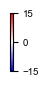

In [ ]:
# Call the function to plot the colorbar
let
    colorbar_plot = "state"

    if colorbar_plot == "sensory"
        plot_colorbar(-40, 40, [0], :bwr, 256)
        fix_plot()
        PyPlot.savefig(joinpath(path_fig_root, "figure7/global_stim_response/sensory_colorbar.pdf"), bbox_inches="tight", transparent=true)
    elseif colorbar_plot == "state"
        plot_colorbar(-15, 15, [0], :bwr, 256)
        fix_plot()
        PyPlot.savefig(joinpath(path_fig_root, "figure7/global_stim_response/state_colorbar.pdf"), bbox_inches="tight", transparent=true)
    elseif colorbar_plot == "ec"
        plot_colorbar(0, 2, [1], :viridis, 256)
        fix_plot()
        PyPlot.savefig(joinpath(path_fig_root, "figure7/global_stim_response/ec_colorbar.pdf"), bbox_inches="tight", transparent=true)
    end
end
# tight_layout()


## Plot average activity of state neurons before vs after stim

Top part of Figure 7J.

Exact Wilcoxon signed rank test
-------------------------------
Population details:
    parameter of interest:   Location parameter (pseudomedian)
    value under h_0:         0
    point estimate:          0.196942
    95% confidence interval: (0.09346, 0.2341)

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-04

Details:
    number of observations:      33
    Wilcoxon rank-sum statistic: 506.0
    rank sums:                   [506.0, 55.0]
    adjustment for ties:         0.0



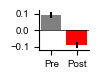

In [ ]:
let
    neuron = "I2"
    act_prestim = Float64[]
    act_poststim = Float64[]
    for (dataset, n) in analysis_dict["matches"][neuron]
        if dataset in datasets_neuropal_baseline
            continue
        end
        mean_all = mean(fit_results[dataset]["trace_original"][n,:])
        push!(act_prestim, mean(fit_results[dataset]["trace_original"][n,1:stim_times[dataset]-1]) / mean_all - 1)
        push!(act_poststim, mean(fit_results[dataset]["trace_original"][n,stim_times[dataset]+1:end]) / mean_all - 1)
    end
    mu_prestim = mean(act_prestim)
    mu_poststim = mean(act_poststim)
    ste_prestim = std(act_prestim) / sqrt(length(act_prestim))
    ste_poststim = std(act_poststim) / sqrt(length(act_poststim))

    println(SignedRankTest(act_prestim, act_poststim))

    figure(figsize=(1,0.8))
    PyPlot.bar([1], [mu_prestim], yerr=[ste_prestim], color="gray")
    PyPlot.bar([2], [mu_poststim], yerr=[ste_poststim], color="red")
    PyPlot.axhline([0.0], color="black", linewidth=0.5)
    PyPlot.xticks(1:2, ["Pre", "Post"])
    fix_plot()
    tight_layout()

    create_dir(joinpath(path_fig_root, "figure7"))
    create_dir(joinpath(path_fig_root, "figure7/state_activity_diff"))
    # PyPlot.savefig(joinpath(path_fig_root, "figure7", "state_activity_diff", "$(neuron)_activity.pdf"))
end

## Goodness of fit

### Bayesian Generalization Index

In [ ]:
let
    analysis_dict["full_posterior"] = [Float64[] for param=1:11]
    num_samples_from_posterior = 100
    for dataset = datasets_baseline
        for rng=1:2
            for neuron = 1:size(fit_results[dataset]["trace_array"],1)
                for i=1:num_samples_from_posterior
                    r = rand(1:size(fit_results[dataset]["sampled_trace_params"],3))
                    for param=1:11
                        push!(analysis_dict["full_posterior"][param], fit_results[dataset]["sampled_trace_params"][rng, neuron, r, param])
                    end
                end
            end
        end
    end
end

In [ ]:
if !("fit_scores" in keys(analysis_dict))
    analysis_dict["fit_scores"] = Dict()
end

for dataset_train = datasets_compute
    n_samples = 500
    analysis_dict["fit_scores"][dataset_train] = Dict()
    dataset_test = dataset_train
    for rng_train = 1:length(fit_results[dataset_train]["ranges"])
        for rng_test = 1:length(fit_results[dataset_train]["ranges"])
            analysis_dict["fit_scores"][dataset_train][(rng_train, rng_test)] = Dict()
            @showprogress for neuron_train = 1:size(fit_results[dataset_train]["trace_array"], 1)
                neuron_test = neuron_train
                analysis_dict["fit_scores"][dataset_train][(rng_train, rng_test)][neuron_train] = zeros(n_samples)
                rand_index = rand(1:size(fit_results[dataset_train]["sampled_trace_params"], 3), n_samples)
                for i = 1:n_samples
                    analysis_dict["fit_scores"][dataset_train][(rng_train, rng_test)][neuron_train][i] =  
                        get_CePNEM_fit_score(fit_results[dataset_train]["sampled_trace_params"][rng_train, neuron_train, rand_index[i], 1:11], 
                            fit_results[dataset_test]["trace_array"][neuron_test, fit_results[dataset_test]["ranges"][rng_test]],
                            fit_results[dataset_test]["v"][fit_results[dataset_test]["ranges"][rng_test]], 
                            fit_results[dataset_test]["θh"][fit_results[dataset_test]["ranges"][rng_test]], 
                            fit_results[dataset_test]["P"][fit_results[dataset_test]["ranges"][rng_test]])
                end
            end
        end
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:21:31
Progress: 100%|█████████████████████████████████████████| Time: 0:24:52
Progress: 100%|█████████████████████████████████████████| Time: 0:17:03
Progress: 100%|█████████████████████████████████████████| Time: 0:17:22
Progress: 100%|█████████████████████████████████████████| Time: 0:32:09
Progress: 100%|█████████████████████████████████████████| Time: 0:32:38
Progress: 100%|█████████████████████████████████████████| Time: 0:15:46
Progress: 100%|█████████████████████████████████████████| Time: 0:16:10
Progress: 100%|█████████████████████████████████████████| Time: 0:33:16
Progress: 100%|█████████████████████████████████████████| Time: 0:33:20
Progress: 100%|█████████████████████████████████████████| Time: 0:16:40
Progress: 100%|█████████████████████████████████████████| Time: 0:16:32
Progress: 100%|█████████████████████████████████████████| Time: 0:29:23
Progress: 100%|█████████████████████████████████████████| Time: 

In [ ]:
if !(haskey(analysis_dict, "full_posterior_scores"))
    analysis_dict["full_posterior_scores"] = Dict()
end
for dataset_train = datasets_compute
    n_samples = 500
    analysis_dict["full_posterior_scores"][dataset_train] = Dict()
    dataset_test = dataset_train
    for rng_test = 1:length(fit_results[dataset_train]["ranges"])
        analysis_dict["full_posterior_scores"][dataset_train][rng_test] = Dict()
        @showprogress for neuron_train = 1:size(fit_results[dataset_train]["trace_array"], 1)
            neuron_test = neuron_train
            analysis_dict["full_posterior_scores"][dataset_train][rng_test][neuron_train] = zeros(n_samples)
            rand_index = rand(1:size(fit_results[dataset_train]["sampled_trace_params"], 3), n_samples)
            for i = 1:n_samples
                analysis_dict["full_posterior_scores"][dataset_train][rng_test][neuron_train][i] =  
                    get_CePNEM_full_posterior_score(analysis_dict["full_posterior"], 
                        fit_results[dataset_test]["trace_array"][neuron_test, fit_results[dataset_test]["ranges"][rng_test]],
                        fit_results[dataset_test]["v"][fit_results[dataset_test]["ranges"][rng_test]], 
                        fit_results[dataset_test]["θh"][fit_results[dataset_test]["ranges"][rng_test]], 
                        fit_results[dataset_test]["P"][fit_results[dataset_test]["ranges"][rng_test]])
            end
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:25
Progress: 100%|█████████████████████████████████████████| Time: 0:07:18
Progress: 100%|█████████████████████████████████████████| Time: 0:07:41
Progress: 100%|█████████████████████████████████████████| Time: 0:07:45
Progress: 100%|█████████████████████████████████████████| Time: 0:09:10
Progress: 100%|█████████████████████████████████████████| Time: 0:09:13
Progress: 100%|█████████████████████████████████████████| Time: 0:09:29
Progress: 100%|█████████████████████████████████████████| Time: 0:09:24
Progress: 100%|█████████████████████████████████████████| Time: 0:09:58
Progress: 100%|█████████████████████████████████████████| Time: 0:10:02
Progress: 100%|█████████████████████████████████████████| Time: 0:10:01
Progress: 100%|█████████████████████████████████████████| Time: 0:10:00
Progress: 100%|█████████████████████████████████████████| Time: 0:09:01
Progress: 100%|█████████████████████████████████████████| Time: 

In [ ]:
analysis_dict["bayesian_generalization_index"] = Dict()
@showprogress for dataset = datasets
    if length(fit_results[dataset]["ranges"]) < 2
        continue
    end
    analysis_dict["bayesian_generalization_index"][dataset] = Dict()
    for rng_test = 1:length(fit_results[dataset]["ranges"])
        analysis_dict["bayesian_generalization_index"][dataset][rng_test] = zeros(size(fit_results[dataset]["trace_array"], 1))
        for neuron = 1:size(fit_results[dataset]["trace_array"], 1)
            analysis_dict["bayesian_generalization_index"][dataset][rng_test][neuron] = compute_cv_accuracy_priorcompare(analysis_dict["fit_scores"][dataset][(3-rng_test, rng_test)][neuron], 
                analysis_dict["full_posterior_scores"][dataset][rng_test][neuron])
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


### Plot ECDF of Bayesian Generalization Index

Any[]
Any[]
0.8878621378621379
0.4567932067932068
0.9197805965032568
0.49022968803565303
0.9067899979670665
0.47662126448465136


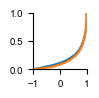

In [ ]:
let
    neuropal_BGI = nothing # BGI for all baseline NeuroPAL datasets
    baseline_BGI = nothing # BGI for all baseline SWF415 datasets
    plot_neuropal = true # Whether to plot NeuroPAL BGI alongside SWF415 in the ECDF

    for datasets_use = [datasets_neuropal_1600, datasets_baseline]
        data_use = [(dataset, rng) for dataset in datasets_use for rng in 1:2]

        bayesian_generalization_index_flattened = vcat([analysis_dict["bayesian_generalization_index"][dataset][rng] for (dataset, rng) in data_use]...)

        if datasets_use == datasets_neuropal_1600
            neuropal_BGI = bayesian_generalization_index_flattened
        else
            baseline_BGI = bayesian_generalization_index_flattened
        end
    end
     
    # you can adjust plotting sections here
    if plot_neuropal
        PyPlot.figure(figsize=(1,1))
    else
        PyPlot.figure(figsize=(1.5,1.5))
    end
    rng_plot = -1:0.001:1


    if plot_neuropal
        PyPlot.plot(rng_plot, ecdf(baseline_goodpumping_full_posterior)(rng_plot))
    else
        PyPlot.plot(rng_plot, ecdf(baseline_goodpumping_full_posterior)(rng_plot), color="gray")
    end

    if plot_neuropal
        PyPlot.plot(rng_plot, ecdf(neuropal_goodpumping_full_posterior)(rng_plot))
    end

    PyPlot.xlim(-1,1.03)
    PyPlot.ylim(0,1)

    fix_plot()
    tight_layout()
end


### Fivefold cross-validation metric

This section requires you to have performed additional CePNEM model fits on the three other folds, besides the first and second half of datasets. You will need to modify the file paths appropriately.

In [ ]:
sampled_trace_params_cv_ = let

    neurons_plotted = Dict()

    neurons_plotted["2021-05-26-07"] = [11,69]
    neurons_plotted["2021-06-11-01"] = [17,66]
    neurons_plotted["2021-08-04-06"] = [10,55,61]
    neurons_plotted["2021-08-17-01"] = [84,91]
    neurons_plotted["2021-11-12-01"] = [104,105]
    neurons_plotted["2021-08-18-01"] = [5,8,79,83,86,90,120,125,131]
    neurons_plotted["2021-09-22-05"] = [15,25,64]

    sampled_trace_params_cv = Dict()
    @showprogress for dataset = datasets_baseline_merged
        sampled_trace_params_cv[dataset] = Dict()
        if !(dataset in keys(neurons_plotted))
            continue
        end
        for rng = [201:1000, 401:1200, 600:1400]
            rng_ = "$(rng[1])to$(rng[end])"
            sampled_trace_params_cv[dataset][rng] = Dict()

            for neuron in neurons_plotted[dataset]
                f = h5open("/data1/adam/data/2023-06-23-fit-gen/result/$(dataset)/$(rng_)/h5/$(neuron).h5", "r")
                sampled_trace_params_cv[dataset][rng][neuron] = f["sampled_trace_params"][:,:]
                close(f)
            end
        end
    end
    sampled_trace_params_cv
end;

Progress:  20%|████████▎                                |  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [ ]:
for dataset in keys(sampled_trace_params_cv_)
    sampled_trace_params_cv[dataset] = sampled_trace_params_cv_[dataset]
end

#### Compute cross-validation model fits

In [ ]:
if !("median_CePNEM_fits_nonextrap_full" in keys(analysis_dict))
    analysis_dict["median_CePNEM_fits_nonextrap_full"] = Dict()
end

let
    datasets_use = deepcopy(datasets_baseline_1600)
    append!(datasets_use, datasets_neuropal_baseline)
    rngs_cv = [201:1000, 401:1200, 600:1400]
    @showprogress for dataset in datasets_baseline_merged
        if !(dataset in keys(sampled_trace_params_cv)) || length(keys(sampled_trace_params_cv[dataset])) == 0
            continue
        end
        analysis_dict["median_CePNEM_fits_nonextrap_full"][dataset] = Dict()
        for rng=1:5
            analysis_dict["median_CePNEM_fits_nonextrap_full"][dataset][rng] = Dict()
            if rng == 1
                rng_t = fit_results[dataset]["ranges"][1]
            elseif rng == 5
                rng_t = fit_results[dataset]["ranges"][2]
            else
                rng_t = rngs_cv[rng-1]
            end
            rng_len = maximum(rng_t) - minimum(rng_t) + 1
            max_t = size(fit_results[dataset]["trace_array"], 2)
            for neuron=keys(sampled_trace_params_cv[dataset][rngs_cv[1]])
                y_fit_array = zeros(max_t, 5000)
                for i=1:size(y_fit_array,2)
                    if rng == 1
                        ps = deepcopy(fit_results[dataset]["sampled_trace_params"][1, neuron, i, 1:8])
                    elseif rng == 5
                        ps = deepcopy(fit_results[dataset]["sampled_trace_params"][2, neuron, i, 1:8])
                    else
                        ps = deepcopy(sampled_trace_params_cv[dataset][rngs_cv[rng-1]][neuron][i, 1:8])
                    end

                    if rng != 1
                        ps[6] = fit_results[dataset]["trace_array"][neuron, 1]
                    end
                    model = model_nl8(max_t, ps..., fit_results[dataset]["v"], fit_results[dataset]["θh"], fit_results[dataset]["P"])
                    y_fit_array[:,i] .= model
                end
                model_fit = median(y_fit_array, dims=2)[:,1]
                analysis_dict["median_CePNEM_fits_nonextrap_full"][dataset][rng][neuron] = model_fit
            end
        end
    end
end
                

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


0.9567567567567568
0.9368879216539717


┌ Warning: Nonoverlapping pumping intervals in 2022-01-17-01 at range 2
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-01-17-01 at range 3
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-04-12-04 at range 4
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-04-12-04 at range 5
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-04-14-04 at range 3
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-04-14-04 at range 5
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-06-14-01 at range 2
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-06-14-13 at range 2
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-06-28-07 at range 4
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-06-28-07 at range 5
└ @ Main In[228]:38
┌ Warning: Nonoverlapping pumping intervals in 2022-07-15-06 at range 3
└ @ Main

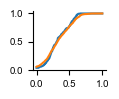

In [ ]:
let

    rngs_cv = [201:1000, 401:1200, 600:1400]
    rngs_test = [801:1120, union(1:200, 1121:1240), union(201:360, 1241:1400), union(1401:1600, 361:480), 481:800]
    use_neuropal = false
    save_fig = false
    twofold = true

    if use_neuropal
        datasets_use = [datasets_baseline_1600, datasets_neuropal_baseline]
        PyPlot.figure(figsize=(1.2,1))
    else
        PyPlot.figure(figsize=(1.5,1.5))
        datasets_use = [datasets_baseline_1600]
    end

    # datasets_use = [datasets_baseline_merged]
    @showprogress for datasets_ = datasets_use
        cv_R2 = Float64[]

        for dataset = datasets_
            if !(dataset in keys(sampled_trace_params_cv)) || length(keys(sampled_trace_params_cv[dataset])) == 0
                continue
            end
            for (i, neuron) = enumerate(keys(analysis_dict["median_CePNEM_fits_nonextrap_full"][dataset][1]))
                cv_neuron = Float64[]
                if twofold
                else
                    for rng=1:5
                        if rng == 1
                            rng_t = fit_results[dataset]["ranges"][1]
                        elseif rng == 5
                            rng_t = fit_results[dataset]["ranges"][2]
                        else
                            rng_t = rngs_cv[rng-1]
                        end

                        # if percentile(fit_results[dataset]["P"][rng_t], 75) < percentile(fit_results[dataset]["P"][rngs_test[rng]], 25)# || percentile(fit_results[dataset]["P"][rng_t], 25) > percentile(fit_results[dataset]["P"][rngs_test[rng]], 75)
                        if percentile(fit_results[dataset]["P"][rng_t], 75) < min(1, percentile(fit_results[dataset]["P"][rngs_test[rng]], 75) - percentile(fit_results[dataset]["P"][rng_t], 75))
                            if i == 1
                                @warn("Nonoverlapping pumping intervals in $dataset at range $rng")
                            end
                            continue
                        end
                        null_model = mean(fit_results[dataset]["trace_array"][neuron, rng_t])
                        model_fit = analysis_dict["median_CePNEM_fits_nonextrap_full"][dataset][rng][neuron][rngs_test[rng]]
                        neuron_activity = fit_results[dataset]["trace_array"][neuron, rngs_test[rng]]
                        push!(cv_neuron, 1 - cost_mse(neuron_activity, model_fit) / cost_mse(neuron_activity, null_model))
                    end
                    if dataset in datasets_baseline_merged
                        println(dataset, " ", neuron, " ", mean(cv_neuron))
                    end
                end
                push!(cv_R2, mean(cv_neuron))
            end
        end
        println(1-ecdf(cv_R2)(0.0))
        if use_neuropal
            PyPlot.plot(0:0.005:1, ecdf(cv_R2)(0:0.005:1))
        else
            PyPlot.plot(0:0.005:1, ecdf(cv_R2)(0:0.005:1), color="black")
        end
        PyPlot.ylim(0,1.05)
        if !use_neuropal
            PyPlot.yticks([0,0.2,0.4,0.6,0.8,1])
        else
            PyPlot.yticks([0,0.5,1])
            PyPlot.xticks([0,0.5,1])
        end
        fix_plot()
        tight_layout()
    end
    if save_fig
        if use_neuropal
            PyPlot.savefig(joinpath(path_fig_root, "figureS4", "updated_cv_neuropal.pdf"), transparent=true)
        else
            PyPlot.savefig(joinpath(path_fig_root, "figureS2", "updated_cv.pdf"), transparent=true)
        end
    end
end

## Extrapolating hierarchical model fits from NeuroPAL datasets (Figure S5E)

You can change `dataset` and `neurons_plot` to plot different datasets and neurons.

RIB: 0.34623073349806044, matches [47]
ASG: 0.5702092558417899, matches [67, 65]
SMDV: 0.6390761507096707, matches [93]
AUA: 1.1160679309675658, matches [58, 21]
CEPD: 1.1397837221539988, matches [9, 36]
URYV: 1.215616773574956, matches [115, 37]
URX: 2.003571425133294, matches [44, 55]
IL1D: 2.0696851386737416, matches [111, 71]
OLQD: 2.59490079912999, matches [108, 4]


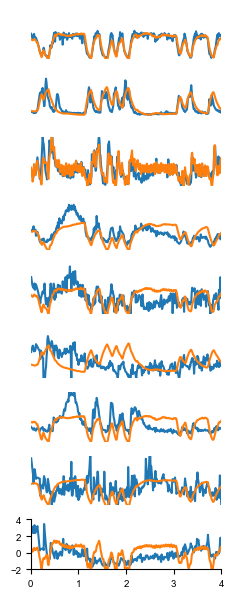

In [ ]:
let
    dataset = "2023-01-16-15"
    neurons_plot = ["RIB", "ASG", "SMDV", "AUA", "CEPD", "URYV", "URX", "IL1D", "OLQD"]
    delta_init = 150
    fig = PyPlot.figure(figsize=(2.35, 6.0))

    stim_dataset = stim_times[dataset] - 1
    v = fit_results[dataset]["v"][1:stim_dataset]
    θh = fit_results[dataset]["θh"][1:stim_dataset] * (2*θh_pos_is_ventral[dataset] - 1)
    P = fit_results[dataset]["P"][1:stim_dataset]

    for (i,neuron) = enumerate(neurons_plot)
        hb_fit_neuron = compute_cartesian_average(analysis_dict["hierarchical_model_params_baselineonly"][neuron], analysis_dict["hierarchical_datasets_baselineonly"][neuron])
        neuron_matches = [x[2] for x in analysis_dict["matches"][neuron] if x[1] == dataset]
        println("$neuron: $(analysis_dict["variability"][neuron]), matches $(neuron_matches)")

        x_rng = (1:stim_dataset-delta_init) .* fit_results[dataset]["avg_timestep"] / 60
        trace = zscore(mean(fit_results[dataset]["trace_array"][neuron_matches,delta_init+1:stim_dataset], dims=1)[1,:])
        model_fit = zscore(model_nl8(stim_dataset, hb_fit_neuron..., v, θh, P)[delta_init+1:end])

        ax = fig.add_subplot(length(neurons_plot),1,i)
        ax.plot(x_rng, trace, label=neuron)
        ax.plot(x_rng, model_fit)
        ax.set_ylim(-2,4)
        ax.set_xlim(0,4)
        ax[:xaxis][:tick_bottom]();
        ax[:yaxis][:tick_left]();
        ax[:spines]["top"]["set_visible"](false);
        ax[:spines]["right"]["set_visible"](false);
        if i != length(neurons_plot)
            ax.spines["bottom"].set_visible(false)
            ax.spines["left"].set_visible(false)
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_xticklabels([])
        else
            ax.set_yticks(-2:2:4)
        end
    end
    fix_plot()
    tight_layout()

    create_dir(joinpath(path_fig_root, "figureS5", "neuropal_cv"))
    PyPlot.savefig(joinpath(path_fig_root, "figureS5", "neuropal_cv", "$(dataset)_allneurons_cvfit.pdf"), transparent=true)
end

## Find inactive neurons

In [ ]:
using CaAnalysis

### Compute 99th percentile of GFP signal

In [ ]:
gfp_signal = let
    gfp_signal_all = Float64[]
    for dataset = datasets_gfp
        for neuron = 1:size(fit_results[dataset]["trace_original"],1)
            push!(gfp_signal_all, analysis_dict["signal"][dataset][neuron])
        end
    end
    percentile(gfp_signal_all, 99)
end

### Fit each GCaMP neuron with a bleaching model to ensure activity is not due to photobleaching

In [ ]:
let
    n_neurons = 0
    n_neurons_lowsignal = 0
    analysis_dict["bleach_fits"] = Dict()
    @showprogress for dataset = datasets_gcamp
        analysis_dict["bleach_fits"][dataset] = Dict()
        for neuron = 1:size(fit_results[dataset]["trace_original"],1)
            analysis_dict["bleach_fits"][dataset][neuron] = Dict()
            trace = fit_results[dataset]["trace_original"][neuron,:]
            _, analysis_dict["bleach_fits"][dataset][neuron]["bleach_param"], y_fit = fit_bleach(trace, 1:length(trace), false, true)
            corrected_trace = trace ./ y_fit
            analysis_dict["bleach_fits"][dataset][neuron]["corrected_trace"] = corrected_trace
            analysis_dict["bleach_fits"][dataset][neuron]["corrected_signal"] = std(corrected_trace) / mean(corrected_trace)
            if analysis_dict["bleach_fits"][dataset][neuron]["corrected_signal"] <= gfp_signal
                n_neurons_lowsignal += 1
            end
            n_neurons += 1
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


0.06784199955367105

### Check fraction of inactive neurons

Note that this may overestimate the true fraction of inactive neurons if neurons have slow signals that could be fit with the photobleaching model.

In [ ]:
let
    n_neurons = 0
    n_neurons_lowsignal = 0
    @showprogress for dataset = datasets_baseline
        for neuron = 1:size(fit_results[dataset]["trace_original"],1)
            if analysis_dict["bleach_fits"][dataset][neuron]["corrected_signal"] <= gfp_signal
                n_neurons_lowsignal += 1
            end
            n_neurons += 1
        end
    end
    n_neurons_lowsignal / n_neurons
end

0.05344655344655345

## Range of head angles during fwd and rev

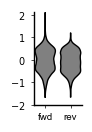

"/data1/prj_kfc/figure/manuscript/cell_draft2/figureS2/hc_range.pdf"

In [ ]:
pyplot()

let
    hc_fwd = Float64[]
    hc_rev = Float64[]
    for dataset = datasets_baseline
        v = fit_results[dataset]["v"]
        hc = fit_results[dataset]["θh"]
        for t=1:length(v)
            if v[t] > 0
                push!(hc_fwd, hc[t]*(1-2*θh_pos_is_ventral[dataset]))
            elseif v[t] < 0
                push!(hc_rev, hc[t]*(1-2*θh_pos_is_ventral[dataset]))
            end
        end
    end
    Plots.plot(size=(80,120), xtickfont=font("Arial", 7, "black"), ytickfont=font("Arial", 7, "black"), tickdirection=:out)
    violin!(hc_fwd, label=nothing, color="grey")
    violin!(hc_rev, label=nothing, color="grey")
    xticks!([1,2], ["fwd", "rev"])
    ylims!(-2.0,2.15)
    Plots.savefig(joinpath(path_fig_root, "figureS2", "hc_range.pdf"))
end

    